In [1]:
# To display multiple outputs from the same cell use the following codes
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Import packages (libraries)

import matplotlib.pyplot as plt


import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import graphviz

#### Project Introduction

Credit risk assessment is a fundamental task for financial institutions. Traditionally, it relies on expert judgment or scorecard systems to evaluate a client's ability to repay. This project leverages machine learning to **automatically classify credit applicants into three distinct risk categories:**

- **Good Client**
- **Low Risk**
- **High Risk**

The model is trained on historical financial and behavioral data to predict the client's risk profile.


**Important:** This is not a binary loan approval model (e.g., Approved/Rejected).

Instead, it aims to provide **a more nuanced, multi-class risk segmentation**, enabling better risk-based decision-making rather than simple application acceptance or denial.

This three-level classification can support more informed and personalized credit/loan strategies by:

This classification can help financial institutions make more informed decisions in areas such as:

- Setting appropriate credit limits
- Adjusting interest rates based on risk
- Enabling early identification of high-risk profiles

By focusing on **risk segmentation**, the model provides financial institutions with a **deeper understanding of client risk**, leading to smarter and **more ethical lending policies.**

By focusing on risk segmentation rather than binary approval, the model provides a more nuanced view of customer risk, enabling smarter and fairer credit policy strategies.

A core focus of the project is to ensure the model remains **fair, transparent, and free of unjust bias**. To achieve this, the model will be:

- Evaluated for fairness across sensitive attributes
- Interpretable using **explainable AI (XAI)** techniques such as SHAP
- Designed to comply with ethical standards in AI-driven credit systems


By automating the credit risk classification process with AI, the project seeks/goal to:
- Improve accuracy in credit risk classification
- Enhance transparency and interpretability of AI models
- Promote fair, responsible, and data-driven lending decisions


In [2]:
app_df = pd.read_csv('application_record.csv')
display(app_df.head())
print(f"Shape of df_application: {app_df.shape}")


credit_df = pd.read_csv('credit_record.csv')
display(credit_df.head())
print(f"Shape of df_credit: {credit_df.shape}")

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


Shape of df_application: (438557, 18)


,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


Shape of df_credit: (1048575, 3)


In [3]:
# Merge datasets on 'ID'
df_merged = pd.merge(app_df, credit_df, on='ID', how='inner')

# Define function to categorize credit risk based on STATUS codes
def categorize_risk(status_values):
    unique_statuses = set(status_values)
    if unique_statuses.issubset({'C', 'X', '0'}):
        return 0  # Good client
    elif any(s in ['3', '4', '5'] for s in status_values):
        return 2  # High risk
    elif any(s in ['1', '2'] for s in status_values):
        return 1  # Low risk
    else:
        return np.nan

# Apply risk classification per client
risk_per_client = credit_df.groupby('ID')['STATUS'].apply(categorize_risk).reset_index()
risk_per_client.columns = ['ID', 'Risk_Level']

# Compute Account Age as the max number of months tracked for each client
account_age = credit_df.groupby('ID')['MONTHS_BALANCE'].min().reset_index()
account_age['Account_Age'] = -account_age['MONTHS_BALANCE']  # make positive
account_age.drop(columns=['MONTHS_BALANCE'], inplace=True)

# Merge Risk_Level and Account_Age back into main application data
app_df = app_df.merge(risk_per_client, on='ID', how='inner')
app_df = app_df.merge(account_age, on='ID', how='inner')

# Final check
print("Risk level distribution:")
print(app_df['Risk_Level'].value_counts())

print("\nAccount Age stats:")
print(app_df['Account_Age'].describe())

display(app_df[['ID', 'Risk_Level', 'Account_Age']].head())
display(app_df.head())


Risk level distribution:
Risk_Level
0    32166
1     3989
2      302
Name: count, dtype: int64

Account Age stats:
count    36457.000000
mean        26.164193
std         16.501854
min          0.000000
25%         12.000000
50%         24.000000
75%         39.000000
max         60.000000
Name: Account_Age, dtype: float64


,ID,Risk_Level,Account_Age
0,5008804,1,15
1,5008805,1,14
2,5008806,0,29
3,5008808,0,4
4,5008809,0,26


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,Risk_Level,Account_Age
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1,15
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1,14
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0,29
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,4
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,26


In [4]:
# Drop duplicated columns from intermediate merges
cols_to_drop = ['Risk_Level_x', 'Account_Age_x', 'Risk_Level_y', 'Account_Age_y']
app_df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Check final structure
print("Final shape:", app_df.shape)
print("Columns:", app_df.columns.tolist())

Final shape: (36457, 20)
Columns: ['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'Risk_Level', 'Account_Age']


##### Custom Risk Label Creation & Account Age Feature (Final Merge Overview)

In this improved modeling setup, I generated a custom target variable (`Risk_Level`) directly from historical credit behavior recorded in `credit_record`.csv. I also engineered a new feature called `Account_Age`, which quantifies how long the credit account history has been active, using the `MONTHS_BALANCE` field.

1. Merge Between Datasets

- Merged `application_record.csv` with the grouped `credit_record.csv` using `ID`.
- The grouped dataset contained:

* `Risk_Level` Multiclass target based on payment history.
* `Account_Age`: Total months of history per client (max = 60 months = 5 years).

- After merging, redundant columns were created (e.g. `Risk_Level_x`, `Risk_Level_y`). These were removed, and the final columns retained were: `Risk_Level` as final label and `Account_Age` as final feature.

- Verified that all `ID` matches were preserved and the new target + feature aligned with the main application dataset.

##### `Risk_Level` (Target Variable) – Class Definitions


| Risk\_Level | Class Label | Description                                                                 |
| ----------- | ----------- | --------------------------------------------------------------------------- |
| 0           | Good Client | No repayment delays (only `STATUS=X`, `STATUS=C` & `STATUS=0` in credit record)|
| 1           | Low Risk    | Minor repayment delays (`STATUS=1` or `STATUS=2`)                        |
| 2           | High Risk   | Significant or repeated delays (`STATUS` ≥ 3)                             |


##### Risk_Level (Target) Distribution

| Risk Level | Count  |
| ---------- | ------ |
| 0 (Good)   | 32,166 |
| 1 (Low)    | 3,989  |
| 2 (High)   | 302    |

This confirms the dataset is **highly imbalanced**, especially for High-Risk clients. This justifies using **SMOTE** or other balancing strategies during model training.


##### Account_Age (Feature) Statistics

| Statistic | Value  |
| --------- | ------ |
| Count     | 36,457 |
| Mean      | 26.16  |
| Std Dev   | 16.50  |
| Min       | 0      |
| 25%       | 12     |
| 50%       | 24     |
| 75%       | 39     |
| Max       | 60     |

This variable is a strong proxy for credit experience: clients with longer account history typically exhibit more stable repayment patterns and are easier to assess in terms of risk. 

In conclusion this revised setup reflects real-world credit risk assessment logic: rather than using an external label, the target is based on actual customer repayment behavior over time. The feature `Account_Age` captures the temporal depth of the client's activity. 

In [5]:
app_df.rename(columns={
    'ID': 'ID',
    'CODE_GENDER': 'Gender',
    'FLAG_OWN_CAR': 'Owns_Car',
    'FLAG_OWN_REALTY': 'Owns_Property',
    'CNT_CHILDREN': 'Children_Count',
    'AMT_INCOME_TOTAL': 'Income',
    'NAME_INCOME_TYPE': 'Income_Type',
    'NAME_EDUCATION_TYPE': 'Education_Level',
    'NAME_FAMILY_STATUS': 'Marital_Status',
    'NAME_HOUSING_TYPE': 'Housing_Type',
    'DAYS_BIRTH': 'Days_Since_Birth',
    'DAYS_EMPLOYED': 'Days_Employed',
    'FLAG_MOBIL': 'Has_Mobile',
    'FLAG_WORK_PHONE': 'Has_Work_Phone',
    'FLAG_PHONE': 'Has_Phone',
    'FLAG_EMAIL': 'Has_Email',
    'OCCUPATION_TYPE': 'Occupation',
    'CNT_FAM_MEMBERS': 'Family_Size',
    'Risk_Level': 'Risk_Level',
    'Account_Age': 'Account_Age'
}, inplace=True)

app_df.head()


,ID,Gender,Owns_Car,Owns_Property,Children_Count,Income,Income_Type,Education_Level,Marital_Status,Housing_Type,Days_Since_Birth,Days_Employed,Has_Mobile,Has_Work_Phone,Has_Phone,Has_Email,Occupation,Family_Size,Risk_Level,Account_Age
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1,15
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1,14
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0,29
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,4
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,26


##### Renaming Features to Readable Names

To improve readability and usability of the dataset, I renamed technical column names into more human-readable forms

| Original Feature      | New Feature Name   | Explanation                          | Remarks                                      |
| --------------------- | ------------------ | ------------------------------------ | -------------------------------------------- |
| `ID`                  | `ID`        | Unique client identifier             |                                              |
| `CODE_GENDER`         | `Gender`           | Client’s gender                      |                                              |
| `FLAG_OWN_CAR`        | `Owns_Car`         | Whether client owns a car            | Binary (Y/N)                                 |
| `FLAG_OWN_REALTY`     | `Owns_Property`    | Whether client owns real estate      | Binary (Y/N)                                 |
| `CNT_CHILDREN`        | `Children_Count`   | Number of children                   |                                              |
| `AMT_INCOME_TOTAL`    | `Income`           | Total annual income                  | In local currency                            |
| `NAME_INCOME_TYPE`    | `Income_Type`      | Source/type of income                | (e.g., Working, Pensioner)                   |
| `NAME_EDUCATION_TYPE` | `Education_Level`  | Highest education level attained     |                                              |
| `NAME_FAMILY_STATUS`  | `Marital_Status`   | Marital status                       |                                              |
| `NAME_HOUSING_TYPE`   | `Housing_Type`     | Housing situation                    | (e.g., Rented, Owned)                        |
| `DAYS_BIRTH`          | `Days_Since_Birth` | Days since birth                     | Negative value (e.g., -12000 means 32 years) |
| `DAYS_EMPLOYED`       | `Days_Employed`    | Days since employment began          | Negative: employed, Positive: unemployed     |
| `FLAG_MOBIL`          | `Has_Mobile`       | Whether client has a mobile phone    | Binary (0/1)                                 |
| `FLAG_WORK_PHONE`     | `Has_Work_Phone`   | Whether client has a work phone      | Binary (0/1)                                 |
| `FLAG_PHONE`          | `Has_Phone`        | Whether client has a home phone      | Binary (0/1)                                 |
| `FLAG_EMAIL`          | `Has_Email`        | Whether client has email             | Binary (0/1)                                 |
| `OCCUPATION_TYPE`     | `Occupation`       | Client’s job type                    | May have missing values                      |
| `CNT_FAM_MEMBERS`     | `Family_Size`      | Total family members in household    | Includes children                            |
| `Risk_Level`          | `Risk_Level`      | Final target: client credit category | {0: Good, 1: Low Risk, 2: High Risk}         |
| `Account_Age`         | `Account_Age`      | Credit account age in months         | From 1 to 60 months                          |




## Data Types and Missing Values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                36457 non-null  int64  
 1   Gender            36457 non-null  object 
 2   Owns_Car          36457 non-null  object 
 3   Owns_Property     36457 non-null  object 
 4   Children_Count    36457 non-null  int64  
 5   Income            36457 non-null  float64
 6   Income_Type       36457 non-null  object 
 7   Education_Level   36457 non-null  object 
 8   Marital_Status    36457 non-null  object 
 9   Housing_Type      36457 non-null  object 
 10  Days_Since_Birth  36457 non-null  int64  
 11  Days_Employed     36457 non-null  int64  
 12  Has_Mobile        36457 non-null  int64  
 13  Has_Work_Phone    36457 non-null  int64  
 14  Has_Phone         36457 non-null  int64  
 15  Has_Email         36457 non-null  int64  
 16  Occupa

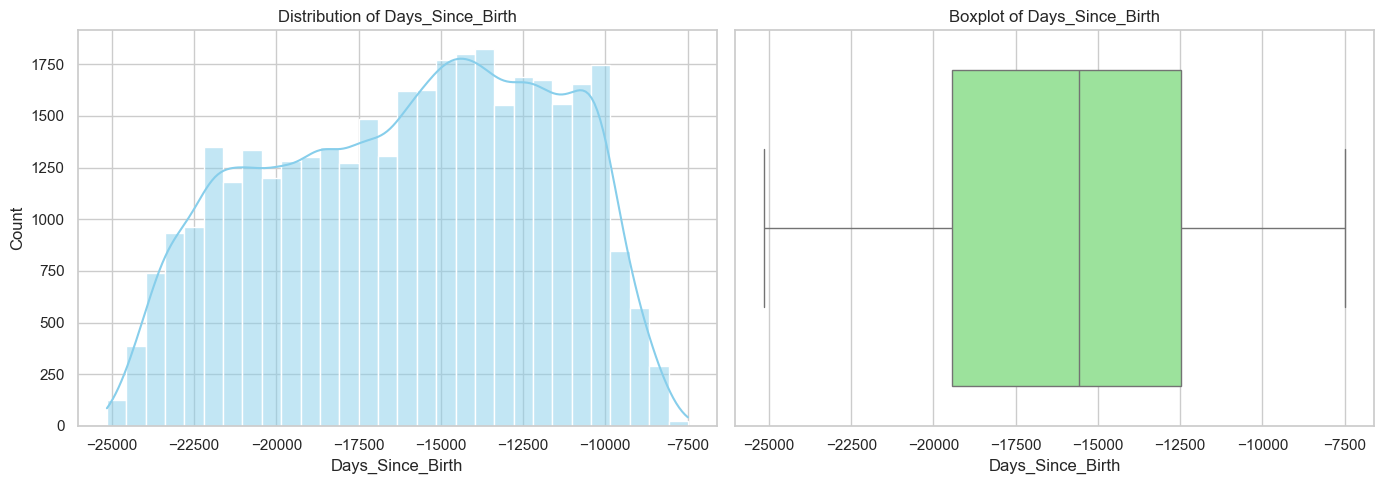


Days_Since_Birth Summary Statistics:
count    36457.000000
mean    -15975.173382
std       4200.549944
min     -25152.000000
25%     -19438.000000
50%     -15563.000000
75%     -12462.000000
max      -7489.000000
Name: Days_Since_Birth, dtype: float64


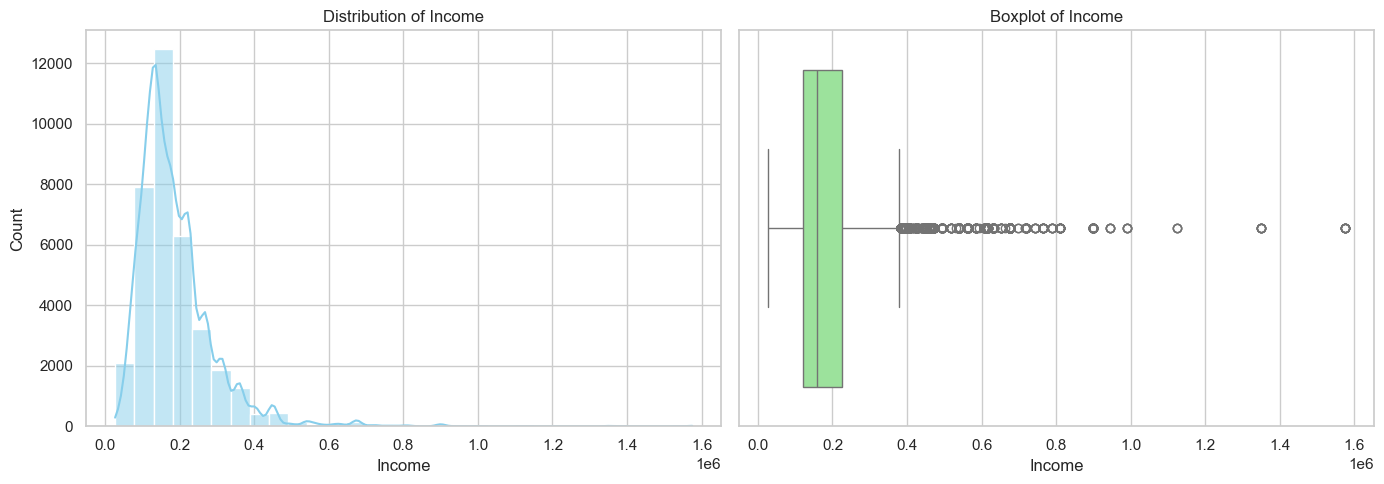


Income Summary Statistics:
count    3.645700e+04
mean     1.866857e+05
std      1.017892e+05
min      2.700000e+04
25%      1.215000e+05
50%      1.575000e+05
75%      2.250000e+05
max      1.575000e+06
Name: Income, dtype: float64


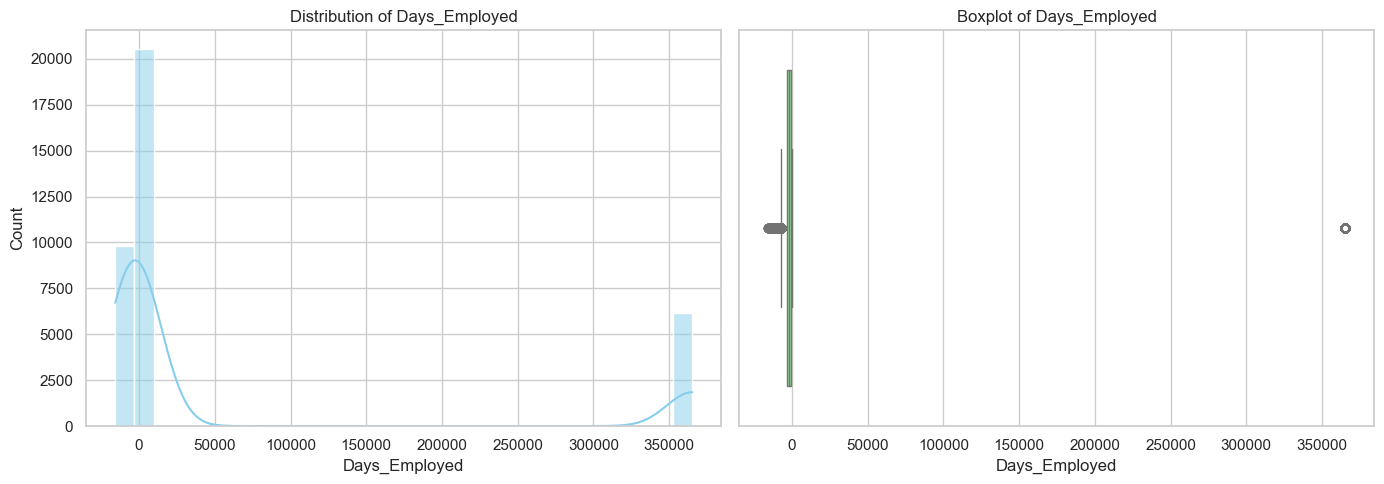


Days_Employed Summary Statistics:
count     36457.000000
mean      59262.935568
std      137651.334859
min      -15713.000000
25%       -3153.000000
50%       -1552.000000
75%        -408.000000
max      365243.000000
Name: Days_Employed, dtype: float64


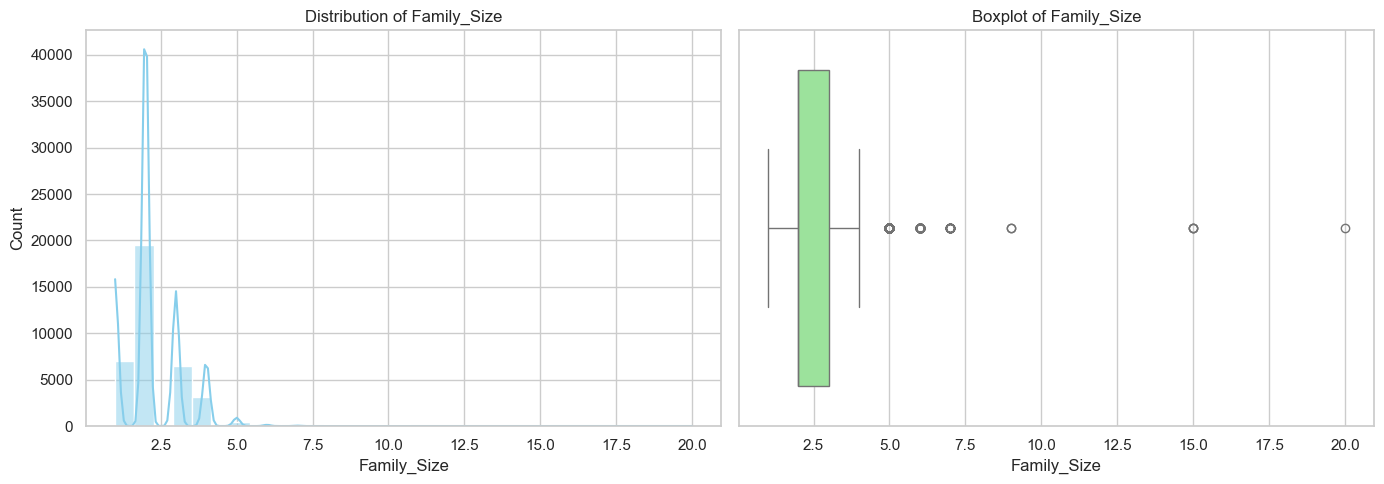


Family_Size Summary Statistics:
count    36457.000000
mean         2.198453
std          0.911686
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         20.000000
Name: Family_Size, dtype: float64


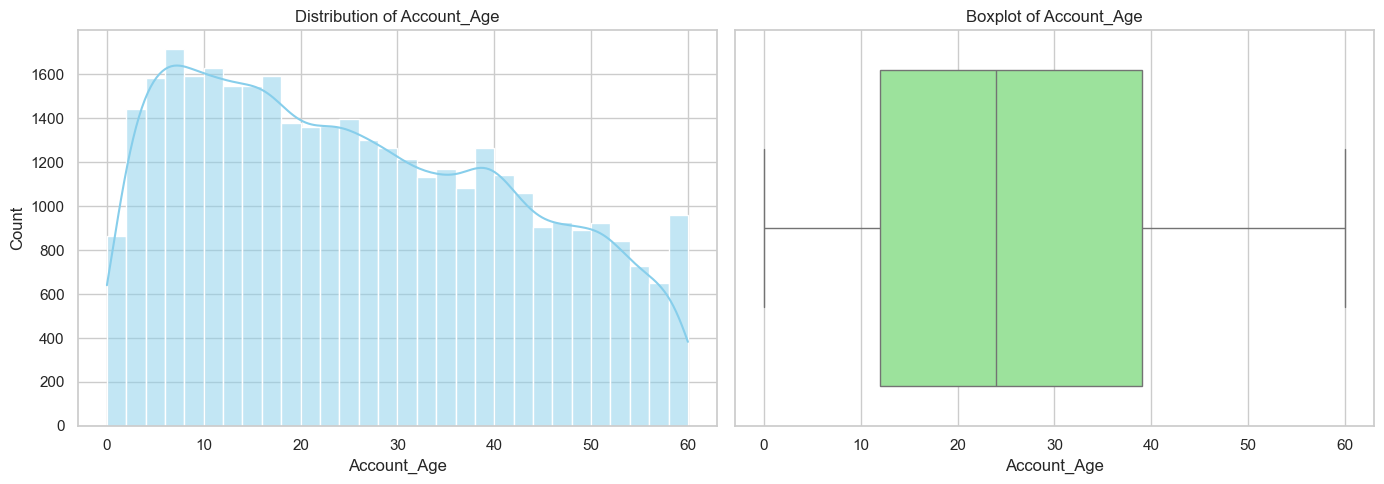


Account_Age Summary Statistics:
count    36457.000000
mean        26.164193
std         16.501854
min          0.000000
25%         12.000000
50%         24.000000
75%         39.000000
max         60.000000
Name: Account_Age, dtype: float64


C:\Users\victo\AppData\Local\Temp\ipykernel_8520\1387709576.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=df, ax=axs[0], palette='viridis', edgecolor='black')


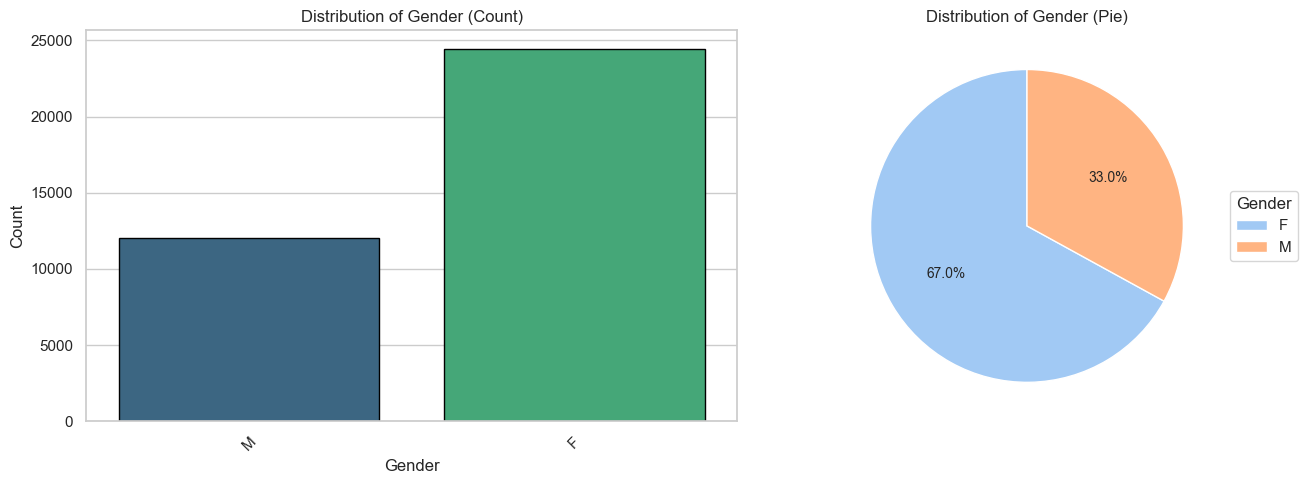


Gender Value Counts (%):
Gender
F    67.01
M    32.99
Name: count, dtype: float64


C:\Users\victo\AppData\Local\Temp\ipykernel_8520\1387709576.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=df, ax=axs[0], palette='viridis', edgecolor='black')


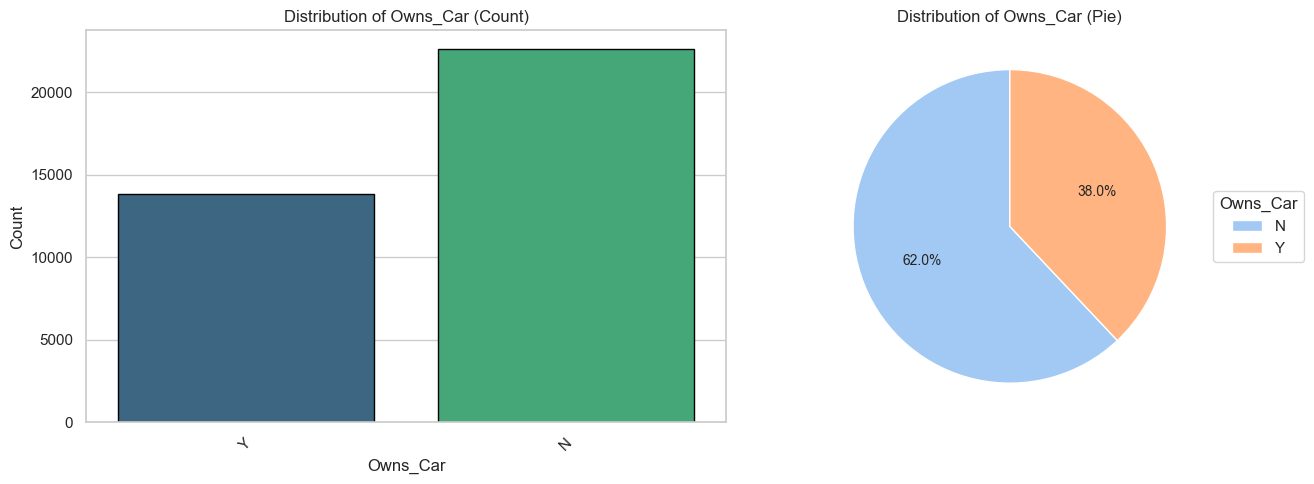


Owns_Car Value Counts (%):
Owns_Car
N    62.03
Y    37.97
Name: count, dtype: float64


C:\Users\victo\AppData\Local\Temp\ipykernel_8520\1387709576.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=df, ax=axs[0], palette='viridis', edgecolor='black')


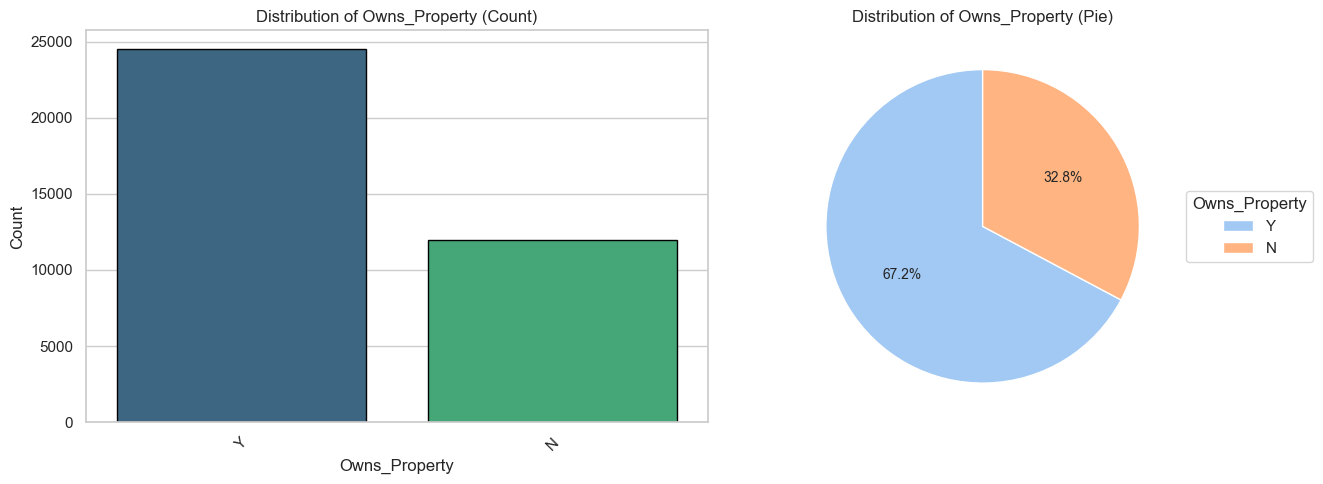


Owns_Property Value Counts (%):
Owns_Property
Y    67.22
N    32.78
Name: count, dtype: float64


C:\Users\victo\AppData\Local\Temp\ipykernel_8520\1387709576.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=percentages.index, y=percentages.values, palette='mako', edgecolor='black')


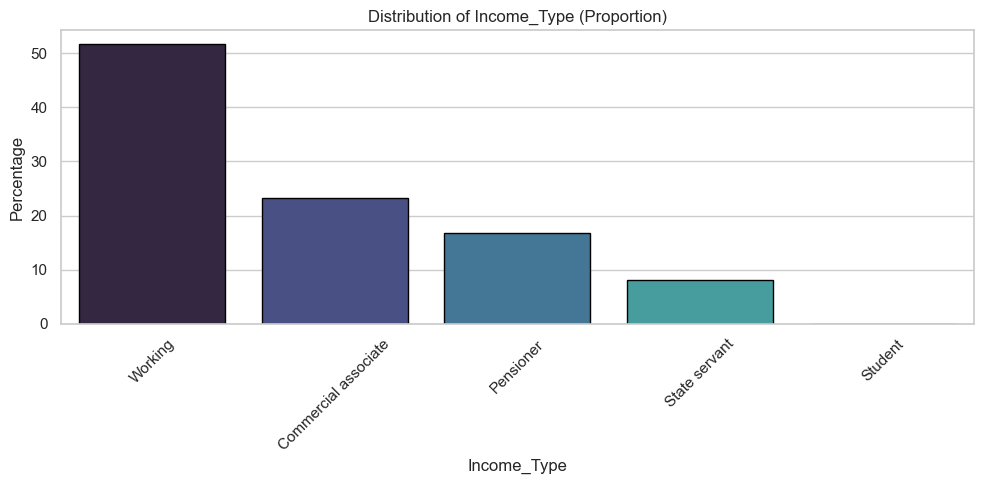


Income_Type Value Counts (%):
Income_Type
Working                 51.62
Commercial associate    23.29
Pensioner               16.87
State servant            8.19
Student                  0.03
Name: proportion, dtype: float64


C:\Users\victo\AppData\Local\Temp\ipykernel_8520\1387709576.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=percentages.index, y=percentages.values, palette='mako', edgecolor='black')


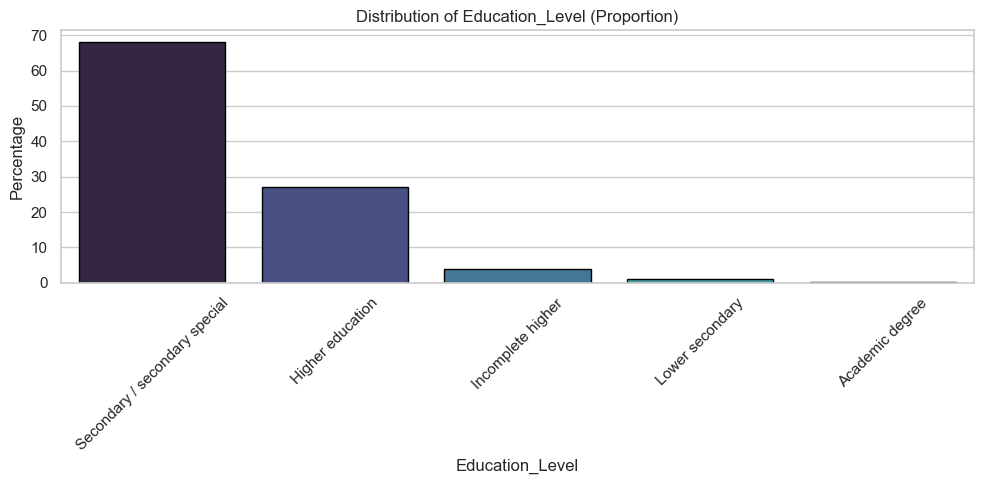


Education_Level Value Counts (%):
Education_Level
Secondary / secondary special    67.96
Higher education                 27.06
Incomplete higher                 3.87
Lower secondary                   1.03
Academic degree                   0.09
Name: proportion, dtype: float64


C:\Users\victo\AppData\Local\Temp\ipykernel_8520\1387709576.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=percentages.index, y=percentages.values, palette='mako', edgecolor='black')


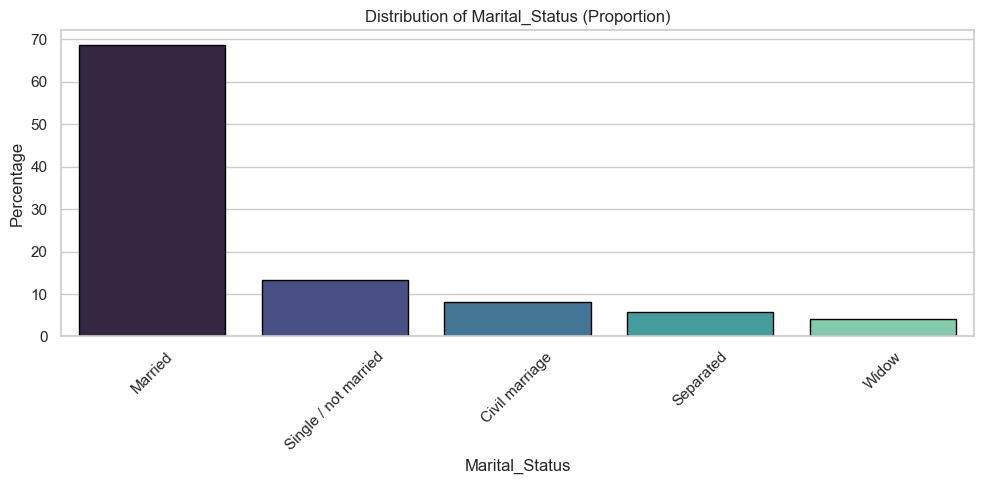


Marital_Status Value Counts (%):
Marital_Status
Married                 68.71
Single / not married    13.25
Civil marriage           8.08
Separated                5.77
Widow                    4.20
Name: proportion, dtype: float64


C:\Users\victo\AppData\Local\Temp\ipykernel_8520\1387709576.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=percentages.index, y=percentages.values, palette='mako', edgecolor='black')


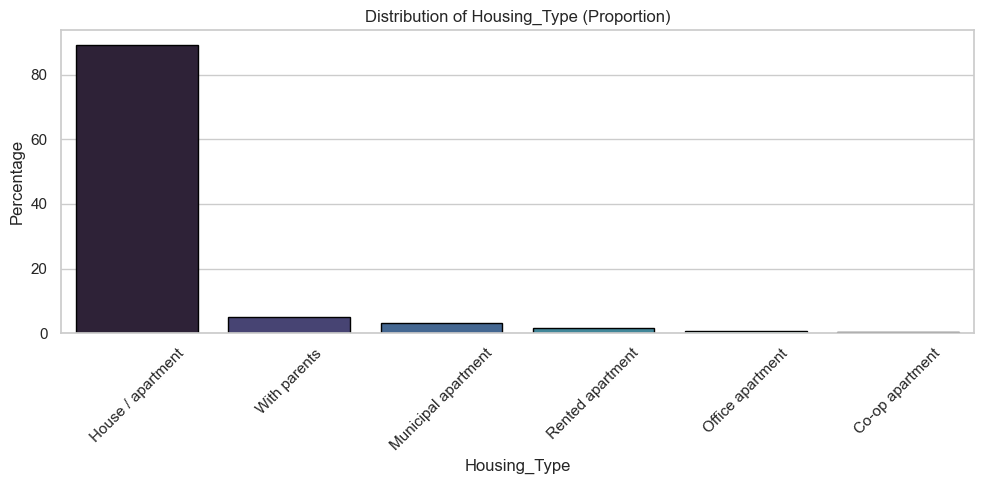


Housing_Type Value Counts (%):
Housing_Type
House / apartment      89.28
With parents            4.87
Municipal apartment     3.09
Rented apartment        1.58
Office apartment        0.72
Co-op apartment         0.46
Name: proportion, dtype: float64


C:\Users\victo\AppData\Local\Temp\ipykernel_8520\1387709576.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=percentages.index, y=percentages.values, palette='mako', edgecolor='black')


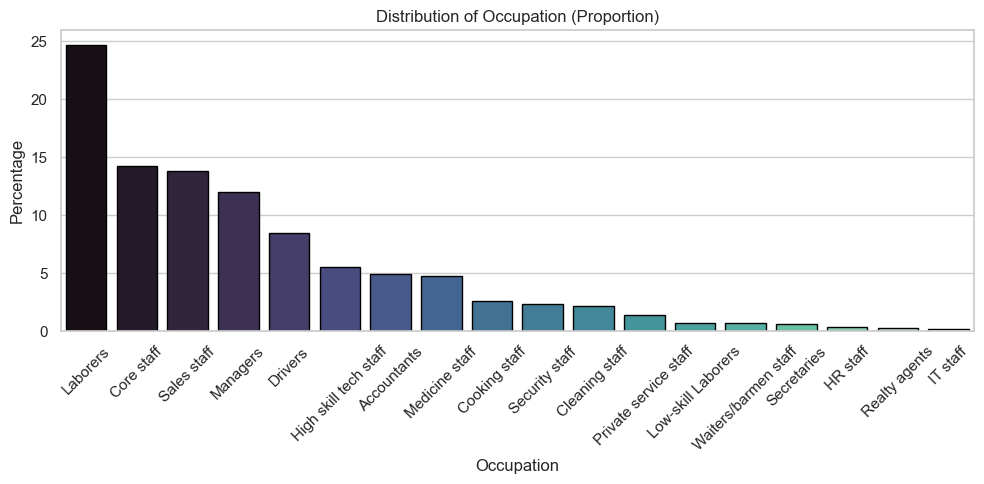


Occupation Value Counts (%):
Occupation
Laborers                 24.71
Core staff               14.29
Sales staff              13.87
Managers                 11.98
Drivers                   8.51
High skill tech staff     5.50
Accountants               4.94
Medicine staff            4.80
Cooking staff             2.61
Security staff            2.36
Cleaning staff            2.19
Private service staff     1.37
Low-skill Laborers        0.70
Waiters/barmen staff      0.69
Secretaries               0.60
HR staff                  0.34
Realty agents             0.31
IT staff                  0.24
Name: proportion, dtype: float64


<Figure size 600x400 with 0 Axes>

C:\Users\victo\AppData\Local\Temp\ipykernel_8520\1387709576.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Risk_Level', data=app_df, palette='Set2')


<Axes: xlabel='Risk_Level', ylabel='count'>

Text(0.5, 1.0, 'Distribution of Credit Risk Levels')

Text(0.5, 0, 'Risk_Level (Target)')

Text(0, 0.5, 'Frequency')

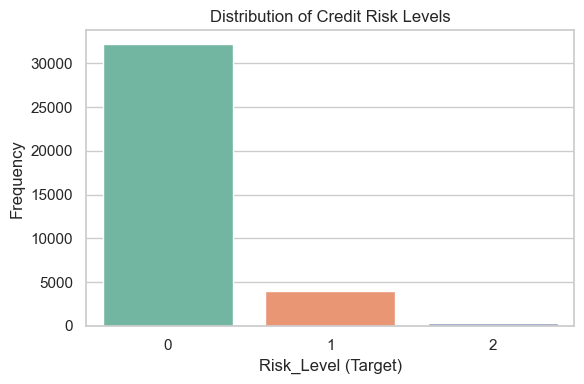


Risk_Level Value Counts (%):
Risk_Level
0    88.23
1    10.94
2     0.83
Name: proportion, dtype: float64


In [6]:

sns.set(style="whitegrid")

# =========================
# 1. Data Overview
# =========================
print("## Data Types and Missing Values\n")
print(app_df.info())

print("\n## Missing Values (%):")
missing_values = (app_df.isnull().sum() / len(app_df)) * 100
print(missing_values.round(2))


# =========================
# 2. Numerical Features
# =========================
def plot_numerical_distribution(df, column):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    sns.histplot(df[column], kde=True, ax=axs[0], bins=30, color='skyblue')
    axs[0].set_title(f'Distribution of {column}')
    axs[0].set_xlabel(column)
    axs[0].set_ylabel('Count')

    sns.boxplot(x=df[column], ax=axs[1], color='lightgreen')
    axs[1].set_title(f'Boxplot of {column}')
    axs[1].set_xlabel(column)

    plt.tight_layout()
    plt.show()

    # Show summary stats below plots
    print(f"\n{column} Summary Statistics:")
    print(df[column].describe())

numerical_cols = ['Days_Since_Birth', 'Income', 'Days_Employed', 'Family_Size', 'Account_Age']
for col in numerical_cols:
    plot_numerical_distribution(app_df, col)

# =========================
# 3. Categorical Features
# =========================

# Categorii scurte -> Pie Chart
short_cats = ['Gender', 'Owns_Car', 'Owns_Property']
# Categorii lungi -> Barplot %
long_cats = ['Income_Type', 'Education_Level', 'Marital_Status', 'Housing_Type', 'Occupation']

def plot_short_categorical(df, column):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    sns.countplot(x=column, data=df, ax=axs[0], palette='viridis', edgecolor='black')
    axs[0].set_title(f'Distribution of {column} (Count)')
    axs[0].set_ylabel('Count')
    axs[0].tick_params(axis='x', rotation=45)

    counts = df[column].value_counts()
    wedges, _, autotexts = axs[1].pie(
        counts, autopct='%1.1f%%', startangle=90,
        colors=sns.color_palette('pastel'), textprops={'fontsize': 10}
    )
    axs[1].legend(wedges, counts.index, title=column, loc='center left', bbox_to_anchor=(1, 0.5))
    axs[1].set_title(f'Distribution of {column} (Pie)')

    plt.tight_layout()
    plt.show()

    print(f"\n{column} Value Counts (%):")
    print((counts / len(df) * 100).round(2))

def plot_long_categorical(df, column):
    plt.figure(figsize=(10, 5))
    percentages = (df[column].value_counts(normalize=True) * 100).sort_values(ascending=False)
    sns.barplot(x=percentages.index, y=percentages.values, palette='mako', edgecolor='black')
    plt.title(f'Distribution of {column} (Proportion)')
    plt.ylabel('Percentage')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print(f"\n{column} Value Counts (%):")
    print(percentages.round(2))

# Rulează pentru ambele tipuri
for col in short_cats:
    plot_short_categorical(app_df, col)

for col in long_cats:
    plot_long_categorical(app_df, col)

# =========================
# 4. Target Variable: Risk_Level
# =========================
plt.figure(figsize=(6, 4))
sns.countplot(x='Risk_Level', data=app_df, palette='Set2')
plt.title('Distribution of Credit Risk Levels')
plt.xlabel('Risk_Level (Target)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

print("\nRisk_Level Value Counts (%):")
print(app_df['Risk_Level'].value_counts(normalize=True).mul(100).round(2))


##### Exploratory Data Analysis (EDA)

This section summarizes the distribution and characteristics of variables in the risk classification dataset after preprocessing. It includes data overview, missing values, and analysis of both numerical and categorical features, with plots and interpretation.


1. Data Types and Missing Values
- There are **36,457 records** and **20 features**.
- Most features are complete, **except `Occupation`**, which has around **30.6% missing values**. This will be handled before modeling.
- `info()` showed that data types are a mix of:
  - `object` (categorical like gender, education), 8 columns
  - `int64` with 10 columns and `float64` with 2 columns (numerical like income or birth days). 

2. Numerical Feature Distributions

Days_Since_Birth: Clients are mostly adults aged 25–60, with a slightly right-skewed distribution. Age is stored as negative days.

 - Count: 36,457, 
 - Mean: ~ -15,975 days (~44 years)
 - Min: -25,152 days (~68.9 years), Max: -7,489 days (~20.5 years)


Income: Strong right skew. Some high-income outliers are visible. Most clients earn below 250,000.

 - Mean: ~186,686
 - Median: 157,500
 - Min: 27,000; Max: 1,575,000

Family_Size: Most clients are from small families. A few outliers with very large families exist and should be handled.

 - Mean: 2.2
 - Median: 2.0
 - Max: 20 (outlier), Most frequent: 2 or 3

Account_Age: Account age peaks around 5–15 months. Data aligns with UK financial regulation to retain records for 5 years (60 months).

 - Mean: ~26 months
 - Median: 24 months
 - Min: 0, Max: 60 months

Days_Employed: Negative values represent "days since current employment started". **365,243** appears often and is a known placeholder in many datasets ( "not working"). These values should be treated separately or replaced with a binary flag (`Is_Employed`).

  - Median: ~ -1,552 days (~4 years)
  - Max: 365,243 --> extremely high value used as flag (likely 'currently unemployed')
  - Strongly skewed


3. Categorical Feature Distributions (Top-Level)

Gender: Majority of clients are female.

| Gender | %     |
| ------ | ----- |
| F      | 67.01 |
| M      | 32.99 |

Owns_Car: Most clients do not own a car.

| Owns\_Car | %     |
| --------- | ----- |
| N         | 62.03 |
| Y         | 37.97 |

Owns_Property: Most clients own property (homeowners).

| Owns\_Property | %     |
| -------------- | ----- |
| Y              | 67.22 |
| N              | 32.78 |

Income_Type: Working individuals dominate, followed by commercial associates.

| Income Type          | %     |
| -------------------- | ----- |
| Working              | 51.62 |
| Commercial associate | 23.29 |
| Pensioner            | 16.87 |
| State servant        | 8.19  |
| Student              | 0.03  |

Education_Level: Most clients have secondary or higher education.

| Education Level               | %     |
| ----------------------------- | ----- |
| Secondary / secondary special | 67.96 |
| Higher education              | 27.06 |
| Incomplete higher             | 3.87  |
| Lower secondary               | 1.03  |
| Academic degree               | 0.09  |

Marital_Status: Most clients are married.

| Marital Status       | %     |
| -------------------- | ----- |
| Married              | 68.71 |
| Single / not married | 13.25 |
| Civil marriage       | 8.08  |
| Separated            | 5.77  |
| Widow                | 4.20  |

Housing_Type: Majority live in a house or apartment they own.

| Housing Type        | %     |
| ------------------- | ----- |
| House / apartment   | 89.28 |
| With parents        | 4.87  |
| Municipal apartment | 3.09  |
| Rented apartment    | 1.58  |
| Office apartment    | 0.72  |
| Co-op apartment     | 0.46  |

Occupation (Top 5): Unskilled or mid-level labor dominates. Occupation is important in creditworthiness. **31% missing values** — consider imputing or treating as 'Unknown'.

| Occupation  | %     |
| ----------- | ----- |
| Laborers    | 24.71 |
| Core staff  | 14.29 |
| Sales staff | 13.87 |
| Managers    | 11.98 |
| Drivers     | 8.51  |

Summary of Categorical Feature Distributions

| Feature            | Most Common Value     | Insight                              |
| ------------------ | --------------------- | ------------------------------------ |
| **Gender**         | Female (67.0%)        | Slightly more female applicants      |
| **Owns\_Car**      | No (62%)              | Majority do not own cars             |
| **Owns\_Property** | Yes (67%)             | Majority own property                |
| **Income\_Type**   | Working (51.6%)       | Most are employed                    |
| **Education**      | Secondary (68%)       | Few with academic degrees            |
| **Marital Status** | Married (69%)         | Married dominates                    |
| **Housing Type**   | House/Apartment (89%) | Stable housing                       |
| **Occupation**     | Laborers (25%)        | Mix of blue-collar jobs; 31% missing |

All charts include both bar plots and pie charts, with full value counts (%) printed after each plot.



4. Target Variable: Credit_Risk

Strong class imbalance exists. Most clients are classified as low-risk or good. Only ~0.8% are high-risk.

| Credit Risk Label | Description | %     |
| ----------------- | ----------- | ----- |
| 0                 | Good Client | 88.23 |
| 1                 | Low Risk    | 10.94 |
| 2                 | High Risk   | 0.83  |











In [7]:

# Impute missing Occupation with 'Unknown'
app_df['Occupation'] = app_df['Occupation'].fillna('Unknown')

# Create binary feature for unemployed
app_df['Is_Unemployed'] = (app_df['Days_Employed'] == 365243).astype(int)

# Replace 365243 with NaN to avoid skewing the distribution
app_df['Days_Employed'] = app_df['Days_Employed'].replace(365243, np.nan)
app_df['Is_Unemployed'] = app_df['Is_Unemployed'].astype('int64') # Convert to int if needed

# 3. Drop irrelevant binary flags
irrelevant_cols = ['Has_Mobile', 'Has_Work_Phone', 'Has_Phone', 'Has_Email']
app_df.drop(columns=irrelevant_cols, inplace=True)

# Distribuția Risk_Level în funcție de Is_Unemployed
distribution = app_df.groupby('Is_Unemployed')['Risk_Level'].value_counts(normalize=True).unstack().round(4) * 100

print("Risk Level Distribution by Employment Status (%):")
print(distribution)

# Confirm changes
print(app_df['Is_Unemployed'].value_counts()) # 0 (Employed ) and 1 (Unemployed or Inactive)
print("\nData cleaned.")
print(app_df.info())
display(app_df.head())


Risk Level Distribution by Employment Status (%):
Risk_Level         0      1     2
Is_Unemployed                    
0              87.92  11.30  0.78
1              89.78   9.18  1.04
Is_Unemployed
0    30322
1     6135
Name: count, dtype: int64

Data cleaned.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                36457 non-null  int64  
 1   Gender            36457 non-null  object 
 2   Owns_Car          36457 non-null  object 
 3   Owns_Property     36457 non-null  object 
 4   Children_Count    36457 non-null  int64  
 5   Income            36457 non-null  float64
 6   Income_Type       36457 non-null  object 
 7   Education_Level   36457 non-null  object 
 8   Marital_Status    36457 non-null  object 
 9   Housing_Type      36457 non-null  object 
 10  Days_Since_Birth  36457 non-null  int64  
 11  Days_Employe

,ID,Gender,Owns_Car,Owns_Property,Children_Count,Income,Income_Type,Education_Level,Marital_Status,Housing_Type,Days_Since_Birth,Days_Employed,Occupation,Family_Size,Risk_Level,Account_Age,Is_Unemployed
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542.0,Unknown,2.0,1,15,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542.0,Unknown,2.0,1,14,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134.0,Security staff,2.0,0,29,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051.0,Sales staff,1.0,0,4,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051.0,Sales staff,1.0,0,26,0


##### Handling Special Case in DAYS_EMPLOYED: Code 365243 as Indicator of Unemployment

In the 'application_record.csv' file, the feature `DAYS_EMPLOYED` represents the number of days since a person was last employed, typically expressed as a negative value ( -1000 means employed for 1000 days).

However, during data exploration, it was observed that many records contain a very large positive value: **365,243**, which clearly stands out from the rest of the distribution. This value does not indicate that a person has been employed for nearly 1000 years. Instead, it's a placeholder used by the data provider to mark individuals who are not employed ( students, retirees, homemakers, unemployed). The number 365,243 likely corresponds to:

365.25 days/year × 1000 years ≈ 365250 --> rounded to 365243

So, it's a sentinel or dummy value — not a real employment duration.

Leaving 365243 untreated would severely skew:

- Statistical summaries (mean, std dev)
- Visualizations like boxplots
- Outlier detection (IQR)
- Feature scaling and model coefficients
- Model fairness (treating unemployment as extreme experience)

To handle this issue responsibly, I applied the following logic:

- Created a binary feature `Is_Unemployed` to capture whether the person is unemployed.
- Replaced the 365243 placeholder in `Is_Unemployed` with NaN so it can be properly handled during feature engineering and preprocessing (imputation, scaling). 

Now: Unemployed clients are now marked with Is_Unemployed = 1, DAYS_EMPLOYED only contains real, clean values for the rest. This change improves model robustness, reduces noise, and adds transparency to how employment status is used in the risk model.

- Is_Unemployed = 0 (30,322): Employed (real employment history)
- Is_Unemployed = 1 (6135): Not employed or inactive (retired, unemployed, homemaker, etc.)


Risk Level Distribution by Employment Status

| Employment Status (`Is_Unemployed`) | Good Client (0) | Low Risk (1) | High Risk (2) |
| ----------------------------------- | --------------- | ------------ | ------------- |
| 0 (Employed)                        | 87.92%          | 11.30%       | 0.78%         |
| 1 (Unemployed)                      | 89.78%          | 9.18%        | 1.04%         |


- Unemployed clients (coded as 365243 in Days_Employed) are slightly more likely to be Good Clients (89.78%) than employed ones (87.92%).
- However, they also show a slightly higher percentage of High Risk clients (1.04%) compared to employed ones (0.78%).

This suggests that `Is_Unemployed` captures some variation in classification risk and might be marginally informative for the model. It's reasonable to keep it as a feature.



In [8]:
# List of numerical columns for outlier analysis
numerical_cols = ['Income', 'Family_Size', 'Days_Since_Birth', 'Days_Employed', 'Account_Age']

# Function to detect outliers using the IQR method
def detect_iqr_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Print outlier counts per column
for col in numerical_cols:
    outliers = detect_iqr_outliers(app_df, col)
    print(f"{col}: {len(outliers)} outliers")

# === Remove outliers ===
def remove_iqr_outliers(df, columns):
    df_cleaned = df.copy()
    for column in columns:
        Q1 = df_cleaned[column].quantile(0.25)
        Q3 = df_cleaned[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_cleaned = df_cleaned[(df_cleaned[column] >= lower_bound) & (df_cleaned[column] <= upper_bound)]
    return df_cleaned

# Apply outlier removal and save the cleaned dataset
df_cleaned_iqr = remove_iqr_outliers(app_df, numerical_cols)

# Compare dataset shapes
print(f"\nOriginal shape: {df_merged.shape}")
print(f"After outlier removal: {df_cleaned_iqr.shape}")


Income: 1529 outliers
Family_Size: 480 outliers
Days_Since_Birth: 0 outliers
Days_Employed: 1741 outliers
Account_Age: 0 outliers

Original shape: (777715, 20)
After outlier removal: (26720, 17)


##### Outlier Detection and Removal (IQR Method)

Outliers can distort the distribution of features and negatively affect the performance of machine learning models. We applied the Interquartile Range (IQR) method to detect and remove outliers in numerical features.

- The dataset is highly imbalanced.
- Some models (Logistic Regression) are sensitive to scale and variance.
- Outliers represent data entry errors or unrealistic values (extremely high income or employment duration).

To improve data quality and ensure more reliable model training, I applied the Interquartile Range (IQR) method to remove outliers from selected numerical columns that showed skewed distributions or known risks of anomalies.

For each numerical feature:

- Q1 (25th percentile) and Q3 (75th percentile) were computed.
- IQR = Q3 - Q1
- Outliers were defined as values below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR.

Outlier Counts Detected

| Feature            | Outliers Detected |
| ------------------ | ----------------- |
| Income             | 1,529             |
| Family\_Size       | 480               |
| Days\_Since\_Birth | 0                 |
| Days\_Employed     | 1,741             |
| Account\_Age       | 0                 |


`Days_Since_Birth` and `Account_Age` had no detected outliers, indicating naturally well-bounded distributions.

Results After Outlier Removal

| Description            | Rows    | Columns |
| ---------------------- | ------- | ------- |
| **Original Dataset**   | 777,715 | 20      |
| **After IQR Cleaning** | 26,720  | 17      |

The dataset was significantly reduced, suggesting that a meaningful number of records contained extreme values in either `Income`, `Family_Size`, or `Days_Employed`. These have now been excluded to ensure more robust model training




In [9]:
# Save the cleaned DataFrame to CSV
df_cleaned_iqr.to_csv('df_clients_cleaned.csv', index=False)

print("Cleaned dataset saved as 'df_clients_cleaned.csv'")

Cleaned dataset saved as 'df_clients_cleaned.csv'


In [10]:
from scipy.stats import chi2_contingency

df = df_cleaned_iqr.copy()

# Ensure Is_Unemployed is treated as a categorical variable
df['Is_Unemployed'] = df['Is_Unemployed'].astype('category')

# List of categorical features to test against Credit_Risk
categorical_features = ['Gender', 'Owns_Car', 'Owns_Property', 'Income_Type',
                        'Education_Level', 'Marital_Status', 'Housing_Type',
                        'Occupation', 'Is_Unemployed']

# Store results
chi2_results = []

# Perform Chi-Squared test for each categorical feature
for feature in categorical_features:
    contingency_table = pd.crosstab(df[feature], df['Risk_Level'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    chi2_results.append({
        'Feature': feature,
        'Chi2 Statistic': round(chi2, 4),
        'Degrees of Freedom': dof,
        'p-value': round(p, 6),
        'Significant (p < 0.05)': 'Yes' if p < 0.05 else 'No'
    })

# Display results
chi2_df = pd.DataFrame(chi2_results)
print("Chi-Squared Test Results:")
display(chi2_df)



Chi-Squared Test Results:


,Feature,Chi2 Statistic,Degrees of Freedom,p-value,Significant (p < 0.05)
0,Gender,6.0090,2,0.049563,Yes
1,Owns_Car,10.5218,2,0.005191,Yes
2,Owns_Property,20.2965,2,0.000039,Yes
3,Income_Type,233.6898,8,0.000000,Yes
4,Education_Level,28.3001,8,0.000420,Yes
5,Marital_Status,21.8679,8,0.005166,Yes
6,Housing_Type,20.8353,10,0.022272,Yes
7,Occupation,83.3158,36,0.000013,Yes
8,Is_Unemployed,0.0000,0,1.000000,No


##### Statistical Association Between Categorical Features and Credit Risk

Before finalizing the categorical features to include in the machine learning model, I performed a Chi-Squared Test of Independence. This test checks whether each categorical variable has a statistically significant association with the target variable `Risk_Level`.

This step ensures that the model only includes variables that are statistically informative, helping to reduce noise and improve model clarity, performance, and fairness.

Why Perform the Chi-Squared Test?

Many variables in the dataset are categorical, such as Gender, Education_Level, or Occupation. It’s not always obvious whether these features influence the Credit_Risk class.

The Chi-Squared test evaluates if the distribution of credit risk classes (0 = Good, 1 = Low Risk, 2 = High Risk) varies significantly across the different categories of each feature.

- Ensures that selected features have a meaningful relationship with the target.
- Reduces the inclusion of noisy or irrelevant variables.
- Fairness auditing of sensitive features like gender or marital status.
- Model robustness and transparency, especially for explainable AI.

Chi-Squared Test Results

| Feature          | Chi2 Statistic | Degrees of Freedom | p-value  | Significant (p < 0.05)? | Interpretation                                               |
| ---------------- | -------------- | ------------------ | -------- | ----------------------- | ------------------------------------------------------------ |
| Gender           | 6.0090         | 2                  | 0.049563 | Yes                   | Weak but statistically significant association.              |
| Owns\_Car        | 10.5218        | 2                  | 0.005191 | Yes                   | Car ownership affects credit risk.                           |
| Owns\_Property   | 20.2965        | 2                  | 0.000039 | Yes                   | Strong correlation with credit behavior.                     |
| Income\_Type     | 233.6898       | 8                  | 0.000000 | Yes                   | Highly predictive and strongly associated with risk.         |
| Education\_Level | 28.3001        | 8                  | 0.000420 | Yes                   | Education influences creditworthiness.                       |
| Marital\_Status  | 21.8679        | 8                  | 0.005166 | Yes                   | Marital status is associated with risk levels.               |
| Housing\_Type    | 20.8353        | 10                 | 0.022272 | Yes                   | Housing context contributes moderately to credit behavior.   |
| Occupation       | 83.3158        | 36                 | 0.000013 | Yes                   | Profession is an important predictor of credit risk.         |
| Is\_Unemployed   | 0.0000         | 0                  | 1.000000 | No                    | No statistical evidence that unemployment status adds value. |


Most features like `Income_Type`, `Occupation`, `Owns_Property`, and `Education_Level` are strongly associated with target. These will be retained in the modeling pipeline.

Dropped Feature: `Is_Unemployed` does not show a meaningful association and may be excluded from the model unless it interacts with other variables in a nonlinear way.

This Chi-Squared analysis justifies categorical feature selection based on evidence, improving the transparency and defensibility of the modeling process.




In [11]:
from scipy.stats import f_oneway

df = df_cleaned_iqr.copy()

# List of numerical features to test
numerical_features = ['Income', 'Family_Size', 'Days_Since_Birth', 'Days_Employed', 'Account_Age']

# Store results
anova_results = []

# Perform one-way ANOVA
for feature in numerical_features:
    groups = [df[df['Risk_Level'] == level][feature].dropna() for level in df['Risk_Level'].unique()]
    f_stat, p_val = f_oneway(*groups)
    
    anova_results.append({
        'Feature': feature,
        'F-Statistic': round(f_stat, 4),
        'p-value': round(p_val, 6),
        'Significant (p < 0.05)': 'Yes' if p_val < 0.05 else 'No'
    })

# Display results
anova_df = pd.DataFrame(anova_results)
print("ANOVA Test Results:")
display(anova_df)


ANOVA Test Results:


,Feature,F-Statistic,p-value,Significant (p < 0.05)
0,Income,0.8628,0.421984,No
1,Family_Size,2.2888,0.101407,No
2,Days_Since_Birth,9.3508,0.000087,Yes
3,Days_Employed,6.1550,0.002126,Yes
4,Account_Age,80.3322,0.000000,Yes


##### Statistical Differences in Numeric Features Using ANOVA (Analysis of Variance)

To understand whether the numerical features in the dataset significantly vary across different levels of credit risk (Good Client, Low Risk, High Risk), I performed ANOVA (Analysis of Variance) tests. This helps determine if the means of a numerical variable differ significantly among the target classes.


When the target variable is categorical and the feature is numerical (like Income, Days_Employed), ANOVA allows us to statistically assess if there are real differences in the average values of the feature across the different credit risk classes.

If the p-value is below 0.05, the difference is considered statistically significant.

ANOVA Results Summary

| Feature                | F-Statistic | p-value  | Significant (p < 0.05) | Interpretation                                                               |
| ---------------------- | ----------- | -------- | ---------------------- | ---------------------------------------------------------------------------- |
| **Income**             | 0.8628      | 0.421984 | No                   | Income does not significantly differ across credit risk levels               |
| **Family\_Size**       | 2.2888      | 0.101407 | No                   | Family size is not a strong predictor of risk by itself                      |
| **Days\_Since\_Birth** | 9.3508      | 0.000087 | Yes                  | Age (as measured from `Days_Since_Birth`) differs across credit risk classes |
| **Days\_Employed**     | 6.1550      | 0.002126 | Yes                  | Employment duration is significantly associated with credit risk             |
| **Account\_Age**       | 80.3322     | 0.000000 | Yes                  | Credit account age is **highly predictive** of credit risk                   |


- `Age` and Credit Experience Matter: Older clients and those with longer account histories show clear differences in credit risk behavior.
- `Income` and `Family Size` are Less Informative: Despite their intuitive importance, these features do not show significant differences across risk levels in this sample.
- `Days_Employed` is useful: Clients who have been employed longer tend to differ in their risk patterns, possibly due to greater financial stability.



<Figure size 1000x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Matrix (Numerical Features + Risk Level)')

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0.5, 0, 'Income'),
  Text(1.5, 0, 'Family_Size'),
  Text(2.5, 0, 'Days_Since_Birth'),
  Text(3.5, 0, 'Days_Employed'),
  Text(4.5, 0, 'Account_Age'),
  Text(5.5, 0, 'Is_Unemployed'),
  Text(6.5, 0, 'Risk_Level')])

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0, 0.5, 'Income'),
  Text(0, 1.5, 'Family_Size'),
  Text(0, 2.5, 'Days_Since_Birth'),
  Text(0, 3.5, 'Days_Employed'),
  Text(0, 4.5, 'Account_Age'),
  Text(0, 5.5, 'Is_Unemployed'),
  Text(0, 6.5, 'Risk_Level')])

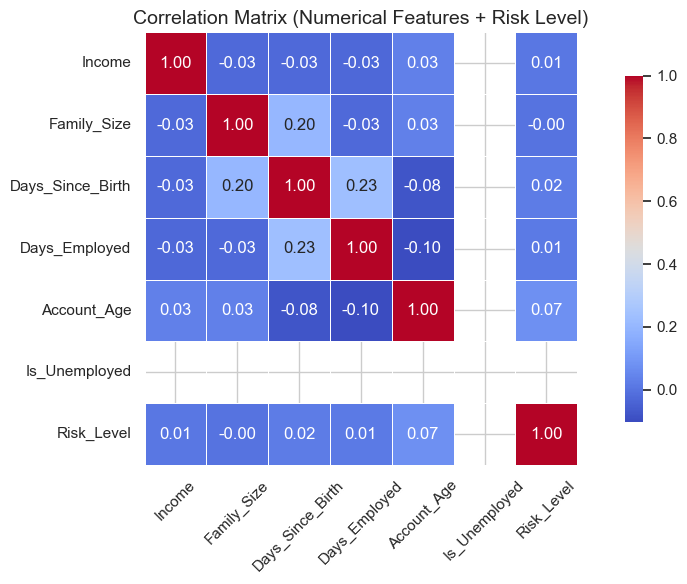


Correlation with Risk Level (sorted):
Account_Age         0.0745
Days_Since_Birth    0.0216
Days_Employed       0.0148
Income              0.0078
Family_Size        -0.0020
Is_Unemployed          NaN
Name: Risk_Level, dtype: float64


In [12]:
    
# Include target to evaluate how correlated each feature is with Risk_Level
numeric_cols_with_target = ['Income', 'Family_Size', 'Days_Since_Birth', 'Days_Employed',
                            'Account_Age', 'Is_Unemployed', 'Risk_Level']

# Compute correlation
corr_matrix = df[numeric_cols_with_target].corr()

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f',
            linewidths=0.5, square=True, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix (Numerical Features + Risk Level)', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print sorted correlation with target
print("\nCorrelation with Risk Level (sorted):")
correlation_with_target = corr_matrix['Risk_Level'].drop('Risk_Level').sort_values(ascending=False)
print(correlation_with_target.round(4))


Correlation Matrix (Numerical Features only):


,Income,Family_Size,Days_Since_Birth,Days_Employed,Account_Age
Income,1.0000,-0.0278,-0.0257,-0.0323,0.0318
Family_Size,-0.0278,1.0000,0.2017,-0.0282,0.0325
Days_Since_Birth,-0.0257,0.2017,1.0000,0.2319,-0.0797
Days_Employed,-0.0323,-0.0282,0.2319,1.0000,-0.1021
Account_Age,0.0318,0.0325,-0.0797,-0.1021,1.0000


<Figure size 1000x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Matrix (Numerical Features Only)')

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0.5, 0, 'Income'),
  Text(1.5, 0, 'Family_Size'),
  Text(2.5, 0, 'Days_Since_Birth'),
  Text(3.5, 0, 'Days_Employed'),
  Text(4.5, 0, 'Account_Age')])

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0, 0.5, 'Income'),
  Text(0, 1.5, 'Family_Size'),
  Text(0, 2.5, 'Days_Since_Birth'),
  Text(0, 3.5, 'Days_Employed'),
  Text(0, 4.5, 'Account_Age')])

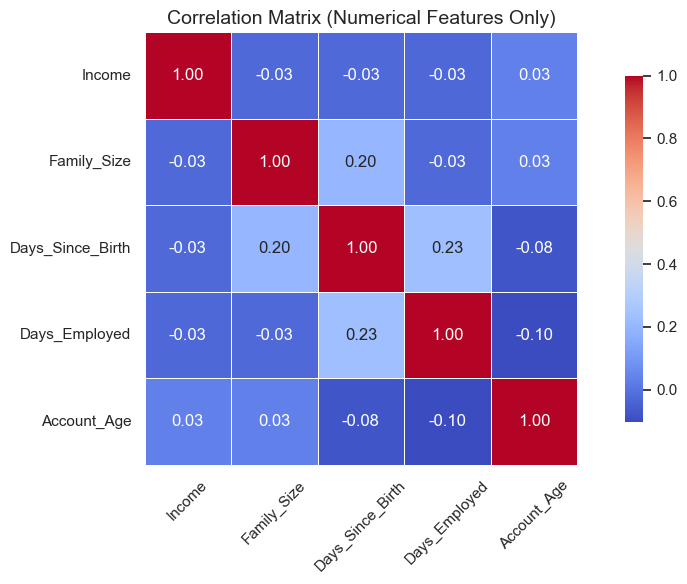

In [13]:
from scipy.stats import pearsonr

# Select relevant numerical features
numerical_features = ['Income', 'Family_Size', 'Days_Since_Birth', 'Days_Employed', 'Account_Age']

# Subset and drop missing values if any
df_numeric = df_cleaned_iqr[numerical_features].dropna()

# Compute pairwise Pearson correlations manually
correlation_df = pd.DataFrame(index=numerical_features, columns=numerical_features)
for i in range(len(numerical_features)):
    for j in range(i, len(numerical_features)):
        var1, var2 = numerical_features[i], numerical_features[j]
        r, _ = pearsonr(df_numeric[var1], df_numeric[var2])
        correlation_df.at[var1, var2] = round(r, 4)
        correlation_df.at[var2, var1] = round(r, 4)

correlation_df = correlation_df.astype(float)

# Print matrix
print("Correlation Matrix (Numerical Features only):")
display(correlation_df)

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt='.2f',
            linewidths=0.5, square=True, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix (Numerical Features Only)', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


##### Correlation Analysis: Numerical Features

1. Correlation Matrix without the target (Credit_Risk)
2. Correlation Matrix including the target (Credit_Risk)

- Evaluate internal relationships between numerical features (for feature redundancy and multicollinearity).
- Understand which features are directly correlated with the credit risk level, which is our prediction target.


1. Correlation Matrix — Without target (`Credit_Risk`)

This matrix focuses only on relationships between numerical features, without considering the target variable. The purpose is to identify collinearity — that is, variables that are strongly correlated and might be redundant or distort the model. 

I excluded target here because I only want to analyze structure between features, not predictive power. This is helpful for feature selection, dimensionality reduction, or understanding which inputs carry overlapping information.

Results:

| Feature 1       | Feature 2          | Correlation |
| --------------- | ------------------ | ----------- |
| Days\_Employed  | Days\_Since\_Birth | **+0.23**   |
| Family\_Size    | Days\_Since\_Birth | +0.20       |
| Days\_Employed  | Account\_Age       | **–0.10**   |
| Remaining pairs | –0.03 to +0.03     | (very weak) |


Full Correlation Matrix:

|                        | Income | Family\_Size | Days\_Since\_Birth | Days\_Employed | Account\_Age |
| ---------------------- | ------ | ------------ | ------------------ | -------------- | ------------ |
| **Income**             | 1.0000 | –0.0278      | –0.0257            | –0.0323        | +0.0318      |
| **Family\_Size**       |        | 1.0000       | +0.2017            | –0.0282        | +0.0325      |
| **Days\_Since\_Birth** |        |              | 1.0000             | +0.2319        | –0.0797      |
| **Days\_Employed**     |        |              |                    | 1.0000         | –0.1021      |
| **Account\_Age**       |        |              |                    |                | 1.0000       |


|                        | Income  | Family\_Size | Days\_Since\_Birth | Days\_Employed | Account\_Age |
| ---------------------- | ------- | ------------ | ------------------ | -------------- | ------------ |
| **Income**             | 1.0000  | -0.0278      | -0.0257            | -0.0323        | 0.0318       |
| **Family\_Size**       | -0.0278 | 1.0000       | 0.2017             | -0.0282        | 0.0325       |
| **Days\_Since\_Birth** | -0.0257 | 0.2017       | 1.0000             | 0.2319         | -0.0797      |
| **Days\_Employed**     | -0.0323 | -0.0282      | 0.2319             | 1.0000         | -0.1021      |
| **Account\_Age**       | 0.0318  | 0.0325       | -0.0797            | -0.1021        | 1.0000       |

- Most features have very weak correlations (close to 0), indicating low linear dependence.
- `Days_Since_Birth` and `Days_Employed` have a moderate positive correlation (0.23), which makes sense: older clients often have longer employment histories.
- `Account_Age` has low-to-very low negative correlation with `Days_Employed` and `Days_Since_Birth`, suggesting a separate dynamic.
- No pair exceeds 0.3, so there’s no multicollinearity concern.





2. Correlation Matrix — With `Risk_Level`

This version includes Credit_Risk to see how predictive each numerical feature is with respect to the classification target.

I cluded target to check whether features like age, income or employment history have predictive power regarding the risk level (Good Client, Low Risk, High Risk).

Results:

| Feature            | Correlation with `Risk_Level` |
| ------------------ | ------------------------------ |
| **Account\_Age**   | **+0.0745** (weak positive)    |
| Days\_Since\_Birth | +0.0216                        |
| Days\_Employed     | +0.0148                        |
| Income             | +0.0078                        |
| Family\_Size       | –0.0020                        |
| Is\_Unemployed     | NaN (due to constant category) |


None of the numerical features show strong correlation with the target.
However, Account_Age is the most predictive, albeit weakly.

- There’s no multicollinearity problem between predictors (no correlations > 0.8).
- `Days_Employed` and `Days_Since_Birth` have a moderate positive correlation → expected, since older clients often have longer work history.
- `Account_Age` is the most informative feature for predicting credit risk, though correlation is still weak (r ≈ 0.07).
- `Income`, `Family_Size`, and `Days_Employed` show minimal correlation, and `Is_Unemployed` returns NaN because it's a binary column with no variance post-cleaning.
- `Is_Unemployed` is not correlated with the target (confirmed also via Chi-Squared test).

Summary

| Matrix Type                | Purpose                      | Includes Target? | Notable Findings                       |
| -------------------------- | ---------------------------- | ---------------- | -------------------------------------- |
| Numerical-only Correlation | Check for multicollinearity  | No             | Low redundancy; 1 moderate correlation |
| Numerical vs. Credit Risk  | Identify predictive features | Yes            | Weak signal; `Account_Age` most useful |




In [14]:
# Load the cleaned dataset from CSV
df_clients_cleaned = pd.read_csv("df_clients_cleaned.csv")

# Optional: confirm it's loaded
print("Loaded shape:", df_clients_cleaned.shape)
print("Columns:", df_clients_cleaned.columns.tolist())


Loaded shape: (26720, 17)
Columns: ['ID', 'Gender', 'Owns_Car', 'Owns_Property', 'Children_Count', 'Income', 'Income_Type', 'Education_Level', 'Marital_Status', 'Housing_Type', 'Days_Since_Birth', 'Days_Employed', 'Occupation', 'Family_Size', 'Risk_Level', 'Account_Age', 'Is_Unemployed']


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures

# ==== Polynomial Features Setup ====
poly = PolynomialFeatures(degree=2, include_bias=False)

# ==== Feature Engineering Function ====
def add_features(df, poly_model=None, fit_poly=False, median_income=None):
    df = df.copy()
    df['Days_Employed'] = df['Days_Employed'].fillna(0)

    # Interaction features
    df['Income_Family_Interaction'] = df['Income'] * df['Family_Size']
    df['Age_Income_Interaction'] = df['Days_Since_Birth'] * df['Income']
    df['Employed_Income_Interaction'] = df['Days_Employed'] * df['Income']

    # Ratio features
    df['Income_Family_Ratio'] = df['Income'] / (df['Family_Size'] + 1e-6)
    df['Income_Age_Ratio'] = df['Income'] / (df['Days_Since_Birth'] + 1e-6)
    df['Income_Employed_Ratio'] = df['Income'] / (df['Days_Employed'] + 1e-6)

    # Binned features
    df['Age_Bin'] = pd.cut(df['Days_Since_Birth'], bins=5, labels=False)
    df['Income_Bin'] = pd.qcut(df['Income'], q=4, labels=False)

    # Polynomial features
    poly_input = df[['Income', 'Days_Since_Birth', 'Days_Employed']]
    if fit_poly:
        poly_array = poly_model.fit_transform(poly_input)
    else:
        poly_array = poly_model.transform(poly_input)

    poly_df = pd.DataFrame(
        poly_array,
        columns=poly_model.get_feature_names_out(['Income', 'Days_Since_Birth', 'Days_Employed']),
        index=df.index
    )

    df = pd.concat([df, poly_df], axis=1)

    # REMOVE duplicated columns first
    df = df.loc[:, ~df.columns.duplicated()]

    # Now it's safe to use 'Income'
    if median_income is None:
        median_income = df['Income'].median()

    df['Income_Above_Median'] = (df['Income'] > median_income).astype(int)

    return df, median_income

# ==== Model input ====
df_model = df_clients_cleaned.copy()
X = df_model.drop(columns=['ID', 'Risk_Level'])
y = df_model['Risk_Level']

# ==== Split into train / val / test ====
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# ==== Feature Engineering ====
X_train_fe, income_median = add_features(X_train, poly_model=poly, fit_poly=True)
X_val_fe, _ = add_features(X_val, poly_model=poly, fit_poly=False, median_income=income_median)
X_test_fe, _ = add_features(X_test, poly_model=poly, fit_poly=False, median_income=income_median)

# ==== Encoding & Scaling ====
categorical_cols = X_train_fe.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X_train_fe.select_dtypes(include=['number']).columns.tolist()

# One-hot encode
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(X_train_fe[categorical_cols])

X_train_enc = encoder.transform(X_train_fe[categorical_cols])
X_val_enc = encoder.transform(X_val_fe[categorical_cols])
X_test_enc = encoder.transform(X_test_fe[categorical_cols])

X_train_enc_df = pd.DataFrame(X_train_enc, columns=encoder.get_feature_names_out(categorical_cols), index=X_train_fe.index)
X_val_enc_df = pd.DataFrame(X_val_enc, columns=encoder.get_feature_names_out(categorical_cols), index=X_val_fe.index)
X_test_enc_df = pd.DataFrame(X_test_enc, columns=encoder.get_feature_names_out(categorical_cols), index=X_test_fe.index)

# Scale numeric
scaler = StandardScaler()
scaler.fit(X_train_fe[numerical_cols])

X_train_scaled = scaler.transform(X_train_fe[numerical_cols])
X_val_scaled = scaler.transform(X_val_fe[numerical_cols])
X_test_scaled = scaler.transform(X_test_fe[numerical_cols])

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numerical_cols, index=X_train_fe.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=numerical_cols, index=X_val_fe.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numerical_cols, index=X_test_fe.index)

# ==== Final datasets ====
X_train_final = pd.concat([X_train_enc_df, X_train_scaled_df], axis=1)
X_val_final = pd.concat([X_val_enc_df, X_val_scaled_df], axis=1)
X_test_final = pd.concat([X_test_enc_df, X_test_scaled_df], axis=1)

# ==== Check class balance ====
print("Class distribution in Train:", y_train.value_counts(normalize=True).round(3))
print("Class distribution in Val:  ", y_val.value_counts(normalize=True).round(3))
print("Class distribution in Test: ", y_test.value_counts(normalize=True).round(3))



OneHotEncoder(handle_unknown='ignore', sparse_output=False)

StandardScaler()

Class distribution in Train: Risk_Level
0    0.880
1    0.112
2    0.007
Name: proportion, dtype: float64
Class distribution in Val:   Risk_Level
0    0.880
1    0.113
2    0.007
Name: proportion, dtype: float64
Class distribution in Test:  Risk_Level
0    0.880
1    0.112
2    0.007
Name: proportion, dtype: float64


##### Feature Engineering: Interactions, Ratios, Binning, Polynomials & Preprocessing

To improve model performance and uncover hidden patterns in the data, I applied advanced feature engineering techniques, capturing both domain-specific relationships and non-linear interactions. This step is especially helpful for models like Logistic Regression or Random Forests, which can benefit from richer, more expressive feature spaces. 

#### Types of Features Engineered

1. Interaction Features: These capture relationships between pairs of features that may jointly influence credit risk:

- Income_Family_Interaction: Income × Family Size
- Age_Income_Interaction: Age × Income
- Employed_Income_Interaction: Days Employed × Income

2. Ratio Features: These capture proportion-based behaviors and allow for better normalization of economic indicators:

- Income_Family_Ratio: Income ÷ Family Size
- Income_Age_Ratio: Income ÷ Age
- Income_Employed_Ratio: Income ÷ Employment Duration

3. Binning Features: These discretize continuous features into categorical bins to allow models to learn thresholds:

- Age_Bin: Equal-width bins from Days_Since_Birth
- Income_Bin: Quartile-based bins from Income

4. Polynomial Features: Using `PolynomialFeatures(degree=2)` on `['Income', 'Days_Since_Birth', 'Days_Employed']`

This expands the feature space with: 
 
- Squared terms (Days_Since_Birth²)
- Interaction terms (Income × Employment)

These features help the model capture non-linear patterns without needing a complex architecture.

5. Domain-Specific Binary Feature: `Income_Above_Median` 1 if income is above the median, 0 otherwise

This allows the model to pick up threshold-based financial patterns that may be relevant to risk.


#### How Feature Engineering Was Applied

A custom function add_features() was created to consistently apply the transformations to all datasets (train, validation, test). 

- `.fit_transform()` used only on the training set to avoid data leakage (especially for PolynomialFeatures and median income).
- `Income` column handling to avoid duplication after polynomial expansion.
- `NaN` values in `Days_Employed` replaced with 0 before mathematical operations.
-  All transformations are stateless and repeatable, ensuring integrity across splits.


#### Dataset Split & Class Distribution Analysis

After feature engineering and preprocessing, the dataset was split into three subsets: **training**, **validation**, and **test**, using stratified sampling to preserve the distribution of the target variable `Risk_Level`.

---

##### Class Distribution in Each Subset

| Subset     | Good Client (0) | Low Risk (1) | High Risk (2) |
|------------|------------------|--------------|----------------|
| **Train**      | 88.0%           | 11.3%         | 0.75%           |
| **Validation** | 88.0%           | 11.3%         | 0.76%           |
| **Test**       | 88.0%           | 11.3%         | 0.76%           |



The class proportions are consistent across all splits thanks to stratification. This ensures a fair evaluation of model performance on minority classes.

---

- The dataset is **heavily imbalanced**, with the **High Risk (2)** class representing less than 1% of all samples.
- This imbalance can lead to poor performance on the minority class if not properly handled.

In conclusion, this feature engineering process enhances the signal in numeric variables while maintaining interpretability. It expands the capacity of linear models like Logistic Regression to capture non-linear patterns, and ensures transparency — a critical requirement in credit risk applications. By applying all transformations only on the training data and using a modular pipeline, overfitting is prevented, and reproducibility is guaranteed.

This feature engineering should sets a solid foundation for modeling by enriching the dataset with meaningful, interpretable features. It balances statistical power with transparency, aligning with the broader goals of fairness and explainability in credit risk assessment.


| Variable        | Description                                                |
|----------------|------------------------------------------------------------|
| `X_train`       | Raw data (categorical + numerical, unprocessed)           |
| `X_train_fe`    | After feature engineering (interactions, ratios, etc.)    |
| `X_train_final` | After One-Hot Encoding + Scaling (ready for ML pipeline)  |



In [16]:
!pip install imbalanced-learn


Training: Logistic Regression


Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=10000,
                                    random_state=42))])

              precision    recall  f1-score   support

           0     0.8994    0.4690    0.6165      3527
           1     0.1219    0.3370    0.1790       451
           2     0.0174    0.5333    0.0336        30

    accuracy                         0.4546      4008
   macro avg     0.3462    0.4464    0.2764      4008
weighted avg     0.8053    0.4546    0.5629      4008



<Figure size 600x400 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Confusion Matrix - Logistic Regression')

Text(0.5, 11.249999999999995, 'Predicted')

Text(42.25, 0.5, 'Actual')

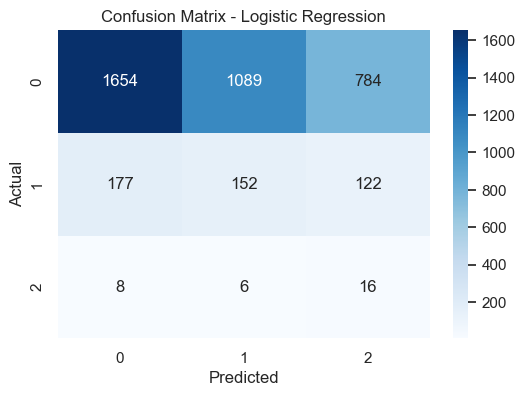

F1 Score (Macro): 0.2764
AUC-ROC (OVR):    0.5832

Training: Random Forest


Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=300, random_state=42))])

              precision    recall  f1-score   support

           0     0.9165    0.9433    0.9297      3527
           1     0.4482    0.3548    0.3960       451
           2     0.5238    0.3667    0.4314        30

    accuracy                         0.8728      4008
   macro avg     0.6295    0.5549    0.5857      4008
weighted avg     0.8609    0.8728    0.8659      4008



<Figure size 600x400 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Confusion Matrix - Random Forest')

Text(0.5, 11.249999999999995, 'Predicted')

Text(42.25, 0.5, 'Actual')

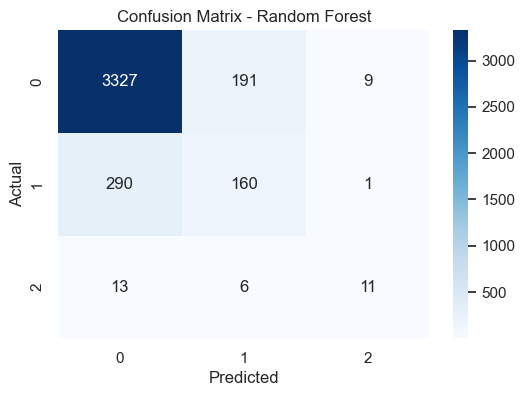

F1 Score (Macro): 0.5857
AUC-ROC (OVR):    0.7839

Training: Gradient Boosting


Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('clf',
                 GradientBoostingClassifier(n_estimators=200,
                                            random_state=42))])

              precision    recall  f1-score   support

           0     0.8928    0.9631    0.9266      3527
           1     0.3722    0.1486    0.2124       451
           2     0.2174    0.1667    0.1887        30

    accuracy                         0.8655      4008
   macro avg     0.4941    0.4261    0.4426      4008
weighted avg     0.8291    0.8655    0.8407      4008



<Figure size 600x400 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Confusion Matrix - Gradient Boosting')

Text(0.5, 11.249999999999995, 'Predicted')

Text(42.25, 0.5, 'Actual')

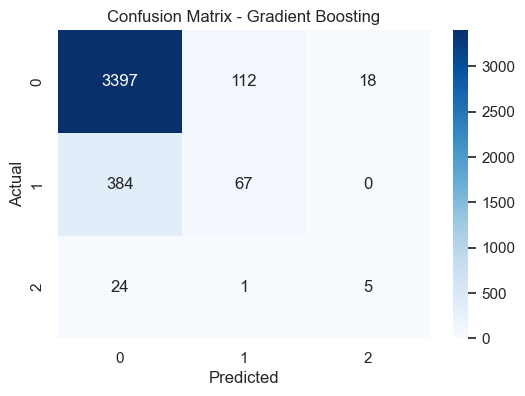

F1 Score (Macro): 0.4426
AUC-ROC (OVR):    0.6679

Training: XGBoost


Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='mlogloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

              precision    recall  f1-score   support

           0     0.9016    0.9685    0.9338      3527
           1     0.4800    0.2129    0.2949       451
           2     0.4211    0.2667    0.3265        30

    accuracy                         0.8782      4008
   macro avg     0.6009    0.4827    0.5184      4008
weighted avg     0.8505    0.8782    0.8574      4008



<Figure size 600x400 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Confusion Matrix - XGBoost')

Text(0.5, 11.249999999999995, 'Predicted')

Text(42.25, 0.5, 'Actual')

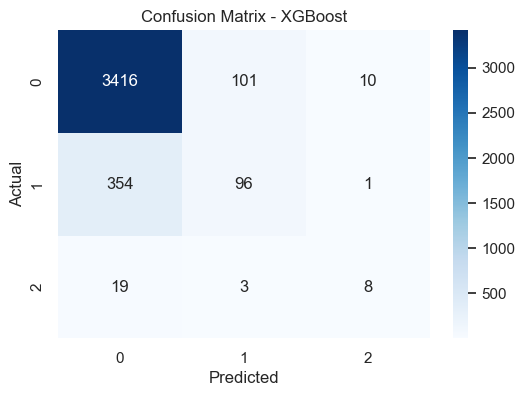

F1 Score (Macro): 0.5184
AUC-ROC (OVR):    0.7280

Training: SVM


Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('clf',
                 SVC(class_weight='balanced', probability=True,
                     random_state=42))])

              precision    recall  f1-score   support

           0     0.9140    0.7559    0.8274      3527
           1     0.2036    0.4479    0.2800       451
           2     0.1111    0.3667    0.1705        30

    accuracy                         0.7183      4008
   macro avg     0.4096    0.5235    0.4260      4008
weighted avg     0.8280    0.7183    0.7609      4008



<Figure size 600x400 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Confusion Matrix - SVM')

Text(0.5, 11.249999999999995, 'Predicted')

Text(42.25, 0.5, 'Actual')

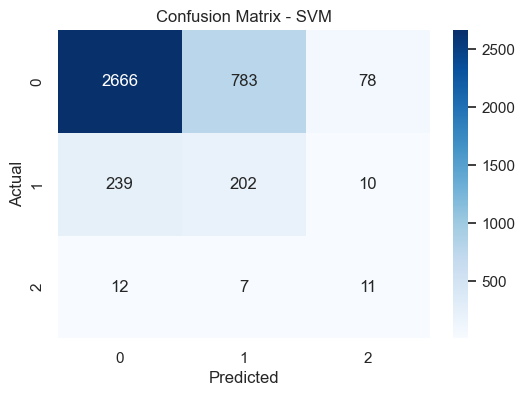

F1 Score (Macro): 0.4260
AUC-ROC (OVR):    0.6634


In [17]:
import warnings

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score

warnings.filterwarnings('ignore')


# === MODELS ===
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "SVM": SVC(probability=True, class_weight='balanced', random_state=42)
}

# === Results ===
results = {}

for name, model in models.items():
    print(f"\nTraining: {name}")

    # SMOTE + model pipeline
    pipe = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf', model)
    ])

    # Fit
    pipe.fit(X_train_final, y_train)

    # Predict
    y_pred = pipe.predict(X_val_final)
    y_prob = pipe.predict_proba(X_val_final)

    # Classification report
    print(classification_report(y_val, y_pred, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Metrics
    f1 = f1_score(y_val, y_pred, average='macro')
    auc = roc_auc_score(y_val, y_prob, multi_class='ovr')

    print(f"F1 Score (Macro): {f1:.4f}")
    print(f"AUC-ROC (OVR):    {auc:.4f}")

    # Save results
    results[name] = {
        "model": pipe,
        "f1_macro": f1,
        "auc_roc": auc,
        "y_pred": y_pred,
        "y_prob": y_prob
    }


#### Model Evaluation (Validation Set)

After applying advanced feature engineering (interaction terms, ratios, binning, polynomial expansion) and careful preprocessing (encoding + scaling), I trained five classification models using the following pipeline:

- **SMOTE**: To balance class distributions
- **StandardScaler** For numerical features
- **OneHotEncoder**  For categorical encoding

- One of five classifiers:
  - Logistic Regression (with `class_weight='balanced'`)
  - Random Forest (300 trees, balanced class weights)
  - Gradient Boosting (200 estimators)
  - XGBoost (default settings with `eval_metric='mlogloss'`)
  - Support Vector Machine (SVM, class_weight='balanced', probability=True)

Each model was evaluated on the **validation set (`X_val_final`)**, using the following metrics:
- Precision, Recall, F1-score (per class)
- F1 Macro Average (for overall performance across all classes)
- AUC-ROC (One-vs-Rest multiclass)
- Confusion Matrix (for interpretability)

---

#### Evaluation Results (Validation)

| Model               | F1 Macro   | AUC-ROC    | Notes                                             |
| ------------------- | ---------- | ---------- | ------------------------------------------------- |
| **Random Forest**   | **0.5857** | **0.7839** | Best performing model overall                     |
| XGBoost             | 0.5184     | 0.7280     | Good class balance                                |
| Gradient Boosting   | 0.4426     | 0.6679     | Underfits minority classes                        |
| SVM                 | 0.4260     | 0.6634     | Better recall on minority class, weak on majority |
| Logistic Regression | 0.2764     | 0.5832     | Poor separation across all classes                |



- Random Forest delivered the highest overall performance, balancing precision and recall across all classes, including minority class (High Risk)
- XGBoost performed slightly worse, but still captured important non-linear patterns in the data.
- Gradient Boosting had strong accuracy on the majority class but struggled with minority detection.
- SVM managed decent recall for Low and High Risk classes but at the cost of overpredicting the majority class as others.
- Logistic Regression struggled to handle the class imbalance, misclassifying the majority of the minority instances.

Notes:

The dataset is heavily imbalanced, especially on class 2 (High Risk ~0.75%).
Even with SMOTE applied, correctly detecting these minority classes remains difficult.
Confusion matrices show that most models still misclassify High Risk as Low or Good.
These results are realistic, indicating a need for further tuning, feature selection, or ensemble methods

Final Evaluation on Test Set


Testing: Logistic Regression
              precision    recall  f1-score   support

           0     0.9149    0.4541    0.6069      3528
           1     0.1397    0.4022    0.2073       450
           2     0.0125    0.4000    0.0242        30

    accuracy                         0.4479      4008
   macro avg     0.3557    0.4188    0.2795      4008
weighted avg     0.8211    0.4479    0.5577      4008



<Figure size 600x400 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Confusion Matrix - Logistic Regression (Test Set)')

Text(0.5, 11.249999999999995, 'Predicted')

Text(42.25, 0.5, 'Actual')

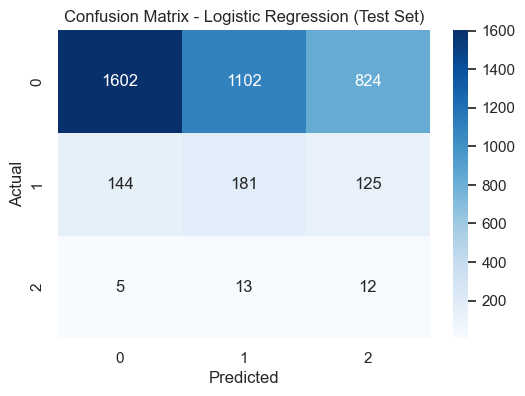

F1 Score (Macro): 0.2795
AUC-ROC (OVR):    0.5782


<Figure size 700x500 with 0 Axes>

Text(0.5, 1.0, 'ROC Curve - Logistic Regression (Test Set)')

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

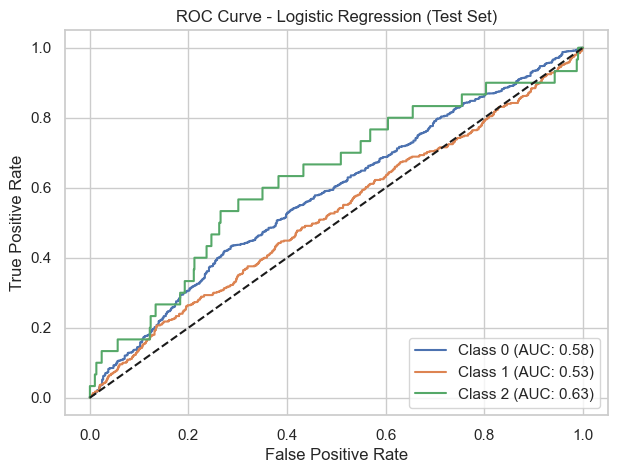


Testing: Random Forest
              precision    recall  f1-score   support

           0     0.9144    0.9294    0.9218      3528
           1     0.3990    0.3600    0.3785       450
           2     0.3125    0.1667    0.2174        30

    accuracy                         0.8598      4008
   macro avg     0.5420    0.4854    0.5059      4008
weighted avg     0.8520    0.8598    0.8556      4008



<Figure size 600x400 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Confusion Matrix - Random Forest (Test Set)')

Text(0.5, 11.249999999999995, 'Predicted')

Text(42.25, 0.5, 'Actual')

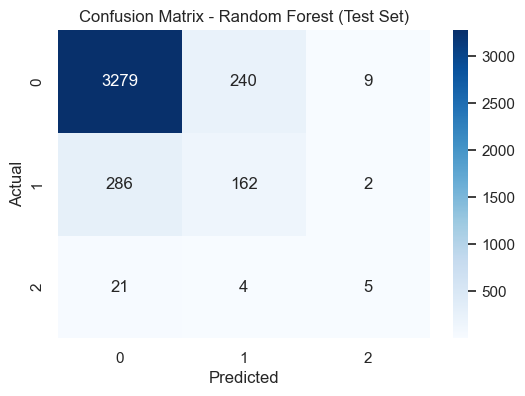

F1 Score (Macro): 0.5059
AUC-ROC (OVR):    0.7789


<Figure size 700x500 with 0 Axes>

Text(0.5, 1.0, 'ROC Curve - Random Forest (Test Set)')

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

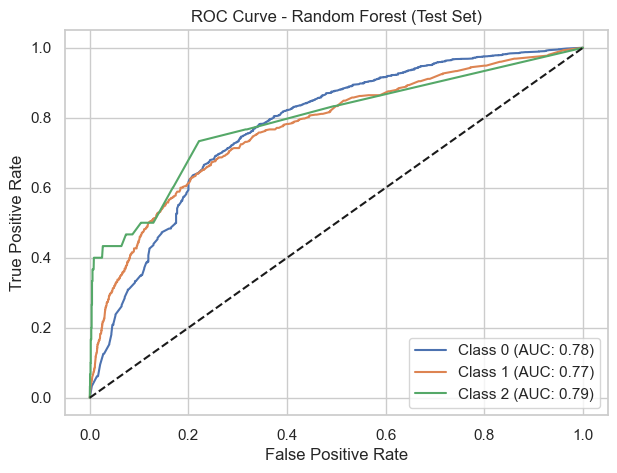


Testing: Gradient Boosting
              precision    recall  f1-score   support

           0     0.8923    0.9677    0.9285      3528
           1     0.3865    0.1400    0.2055       450
           2     0.1053    0.0667    0.0816        30

    accuracy                         0.8680      4008
   macro avg     0.4614    0.3915    0.4052      4008
weighted avg     0.8296    0.8680    0.8410      4008



<Figure size 600x400 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Confusion Matrix - Gradient Boosting (Test Set)')

Text(0.5, 11.249999999999995, 'Predicted')

Text(42.25, 0.5, 'Actual')

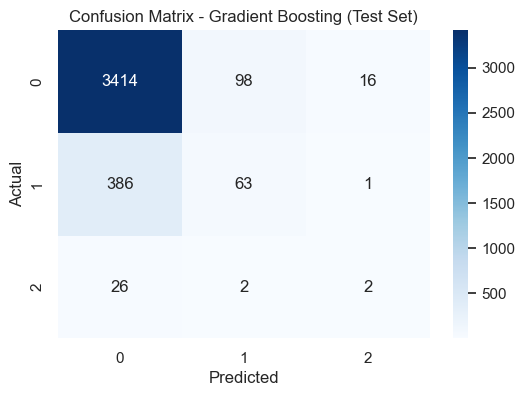

F1 Score (Macro): 0.4052
AUC-ROC (OVR):    0.6748


<Figure size 700x500 with 0 Axes>

Text(0.5, 1.0, 'ROC Curve - Gradient Boosting (Test Set)')

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

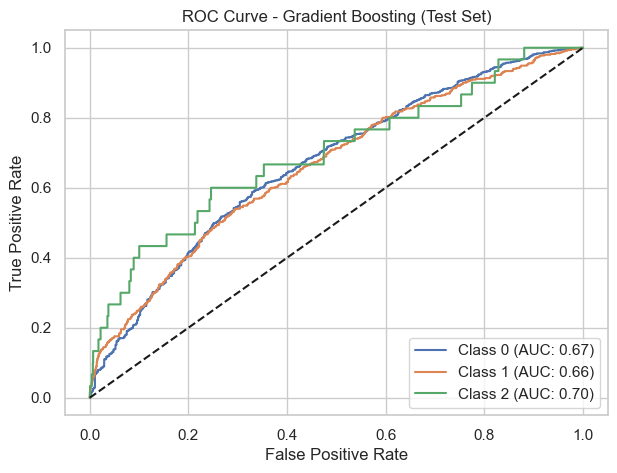


Testing: XGBoost
              precision    recall  f1-score   support

           0     0.9054    0.9660    0.9347      3528
           1     0.4935    0.2533    0.3348       450
           2     0.3077    0.1333    0.1860        30

    accuracy                         0.8797      4008
   macro avg     0.5689    0.4509    0.4852      4008
weighted avg     0.8547    0.8797    0.8618      4008



<Figure size 600x400 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Confusion Matrix - XGBoost (Test Set)')

Text(0.5, 11.249999999999995, 'Predicted')

Text(42.25, 0.5, 'Actual')

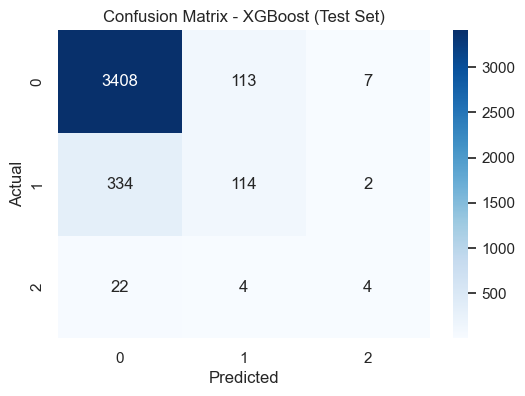

F1 Score (Macro): 0.4852
AUC-ROC (OVR):    0.7392


<Figure size 700x500 with 0 Axes>

Text(0.5, 1.0, 'ROC Curve - XGBoost (Test Set)')

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

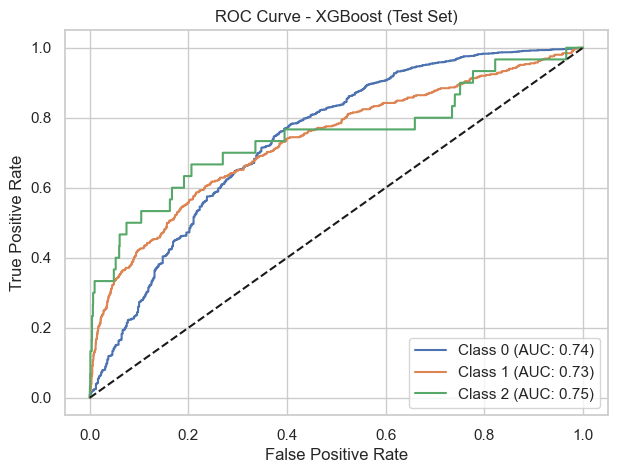


Testing: SVM
              precision    recall  f1-score   support

           0     0.9194    0.7568    0.8302      3528
           1     0.2141    0.4733    0.2948       450
           2     0.0734    0.2667    0.1151        30

    accuracy                         0.7213      4008
   macro avg     0.4023    0.4989    0.4134      4008
weighted avg     0.8339    0.7213    0.7648      4008



<Figure size 600x400 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Confusion Matrix - SVM (Test Set)')

Text(0.5, 11.249999999999995, 'Predicted')

Text(42.25, 0.5, 'Actual')

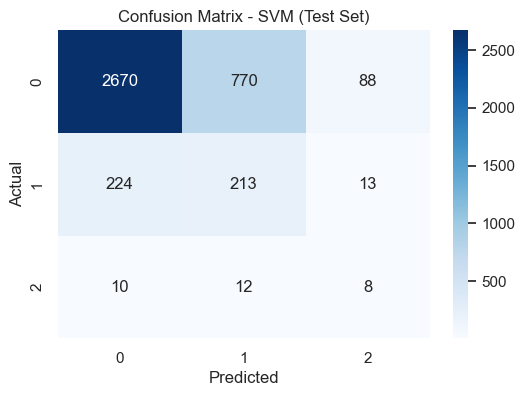

F1 Score (Macro): 0.4134
AUC-ROC (OVR):    0.6924


<Figure size 700x500 with 0 Axes>

Text(0.5, 1.0, 'ROC Curve - SVM (Test Set)')

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

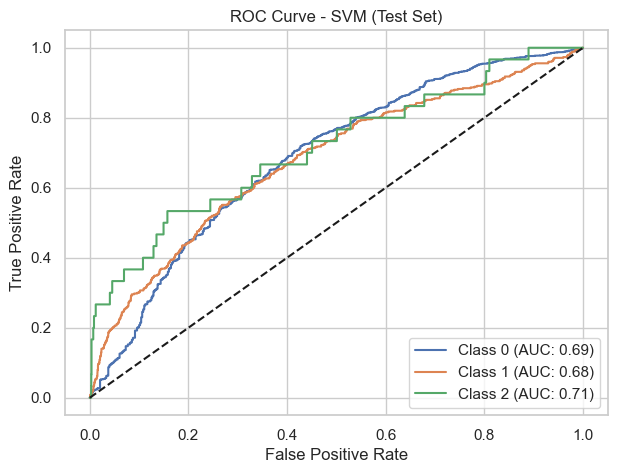

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, roc_curve
from sklearn.preprocessing import label_binarize


print("Final Evaluation on Test Set\n")

# One-hot encode y_test for ROC curve (needed for multiclass ROC)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

for name, entry in results.items():
    model = entry['model']
    print(f"\nTesting: {name}")

    # Predict on test set
    y_pred = model.predict(X_test_final)
    y_prob = model.predict_proba(X_test_final)

    # Classification report
    print(classification_report(y_test, y_pred, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name} (Test Set)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # F1 Score (Macro) & AUC-ROC
    f1 = f1_score(y_test, y_pred, average='macro')
    auc = roc_auc_score(y_test_bin, y_prob, multi_class='ovr')

    print(f"F1 Score (Macro): {f1:.4f}")
    print(f"AUC-ROC (OVR):    {auc:.4f}")

    # ROC Curve per class
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])

    # Plot all ROC curves
    plt.figure(figsize=(7, 5))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC: {roc_auc_score(y_test_bin[:, i], y_prob[:, i]):.2f})")
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"ROC Curve - {name} (Test Set)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


##### Model Evaluation (Test Set)

After final feature engineering and SMOTE balancing, we evaluated all five trained classifiers on the test set (X_test_final) using:

- Classification Report (Precision, Recall, F1-score per class)
- Macro-averaged F1 Score
- AUC-ROC (One-vs-Rest, per class and overall)
- Confusion Matrix
- ROC Curves

Test Set Results Summary

| Model                   | F1 Macro | AUC-ROC | Notes                                           |
| ----------------------- | -------- | ------- | ----------------------------------------------- |
| **Logistic Regression** | 0.2795   | 0.5782  | Strong bias toward majority class (0)           |
| **Random Forest**       | 0.5059   | 0.7789  | Good balance, but struggles with minority class |
| **Gradient Boosting**   | 0.4052   | 0.6748  | Accurate for class 0, weak for 1 and 2          |
| **XGBoost**             | 0.4852   | 0.7392  | Best performance on minority classes            |
| **SVM**                 | 0.4134   | 0.6924  | Decent overall, still underperforms on class 2  |


- Class 0 (Good Client) is predicted well by all models (Precision > 0.89, Recall > 0.75).
- Class 1 (Low Risk) is challenging: misclassified as class 0 in many cases.
- Class 2 (High Risk) is the most difficult to detect due to low prevalence (0.75%).

Confusion Matrix

- Logistic Regression: heavy confusion across all classes.
- Random Forest & XGBoost: clearer separation, especially for Class 0.
- SVM: performs better than expected, but still weak on Class 2.

ROC Curves

- Logistic Regression: 0.58 (0), 0.53 (1), 0.63 (2)
- Random Forest: 0.78 (0), 0.77 (1), 0.79 (2)
- Gradient Boosting: 0.67 (0), 0.66 (1), 0.70 (2)
- XGBoost: 0.74 (0), 0.73 (1), 0.75 (2)
- SVM: 0.69 (0), 0.68 (1), 0.71 (2)

The best ROC curves (closest to 1.0) belong to Random Forest and XGBoost, showing better probabilistic calibration

In conclusion Random Forest and XGBoost offer the best generalization on unseen data. Despite high overall accuracy, macro F1 and ROC show room for improvement on minority classes.



In [19]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


# === Pipeline creator ===
def create_pipeline(model):
    return ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('scaler', StandardScaler()),
        ('model', model)
    ])

# ==== 1. Logistic Regression (GridSearchCV) ====
lr_param_grid = {
    'model__C': [1e2, 1e4, 1e6, 1e8, 1e10, 1e12],
    'model__penalty': ['l2'],
    'model__solver': ['liblinear']
}
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_search = GridSearchCV(
    create_pipeline(lr_model),
    param_grid=lr_param_grid,
    cv=5,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1
)

# ==== 2. Random Forest (RandomizedSearchCV) ====
rf_param_dist = {
    'model__n_estimators': [200, 300, 400],
    'model__max_depth': [20, 30, 40],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_search = RandomizedSearchCV(
    create_pipeline(rf_model),
    param_distributions=rf_param_dist,
    n_iter=10,
    cv=5,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# ==== 3. Gradient Boosting (RandomizedSearchCV) ====
gb_param_dist = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.1, 0.3, 0.5],
    'model__max_depth': [3, 5, 7],
    'model__subsample': [0.8, 1.0]
}
gb_model = GradientBoostingClassifier(random_state=42)
gb_search = RandomizedSearchCV(
    create_pipeline(gb_model),
    param_distributions=gb_param_dist,
    n_iter=10,
    cv=5,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# ==== 4. XGBoost (RandomizedSearchCV) ====
xgb_param_dist = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.1, 0.3, 0.5],
    'model__max_depth': [3, 5, 7],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_search = RandomizedSearchCV(
    create_pipeline(xgb_model),
    param_distributions=xgb_param_dist,
    n_iter=10,
    cv=5,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# ==== 5. SVM (GridSearchCV) ====
svm_param_grid = {
    'model__C': [0.1, 1, 10],
    'model__kernel': ['linear', 'rbf'],
    'model__gamma': ['scale', 'auto']
}
svm_model = SVC(class_weight='balanced', probability=True, random_state=42)
svm_search = GridSearchCV(
    create_pipeline(svm_model),
    param_grid=svm_param_grid,
    cv=5,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1
)

# ==== RUN TUNING (pe X_train_final) ====
print("Optimizing: Logistic Regression")
lr_search.fit(X_train_final, y_train)
print("Best params for Logistic Regression:", lr_search.best_params_)

print("\nOptimizing: Random Forest")
rf_search.fit(X_train_final, y_train)
print("Best params for Random Forest:", rf_search.best_params_)

print("\nOptimizing: Gradient Boosting")
gb_search.fit(X_train_final, y_train)
print("Best params for Gradient Boosting:", gb_search.best_params_)

print("\nOptimizing: XGBoost")
xgb_search.fit(X_train_final, y_train)
print("Best params for XGBoost:", xgb_search.best_params_)

print("\nOptimizing: SVM")
svm_search.fit(X_train_final, y_train)
print("Best params for SVM:", svm_search.best_params_)


Optimizing: Logistic Regression
Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('scaler', StandardScaler()),
                                       ('model',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'model__C': [100.0, 10000.0, 1000000.0, 100000000.0,
                                      10000000000.0, 1000000000000.0],
                         'model__penalty': ['l2'],
                         'model__solver': ['liblinear']},
             scoring='f1_macro', verbose=1)

Best params for Logistic Regression: {'model__C': 10000.0, 'model__penalty': 'l2', 'model__solver': 'liblinear'}

Optimizing: Random Forest
Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                             ('scaler', StandardScaler()),
                                             ('model',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'model__max_depth': [20, 30, 40],
                                        'model__min_samples_leaf': [1, 2, 4],
                                        'model__min_samples_split': [2, 5, 10],
                                        'model__n_estimators': [200, 300, 400]},
                   random_state=42, scoring='f1_macro', verbose=1)

Best params for Random Forest: {'model__n_estimators': 300, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_depth': 30}

Optimizing: Gradient Boosting
Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                             ('scaler', StandardScaler()),
                                             ('model',
                                              GradientBoostingClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'model__learning_rate': [0.1, 0.3, 0.5],
                                        'model__max_depth': [3, 5, 7],
                                        'model__n_estimators': [100, 200, 300],
                                        'model__subsample': [0.8, 1.0]},
                   random_state=42, scoring='f1_macro', verbose=1)

Best params for Gradient Boosting: {'model__subsample': 1.0, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__learning_rate': 0.5}

Optimizing: XGBoost
Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                             ('scaler', StandardScaler()),
                                             ('model',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric='mlogloss',
                                                            feature_types=None...
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None, ...))]),
                   n_jobs=-1,
                   param_distributions={'model__colsample_bytree': [0.8, 1.0],
                                        'model__learning_rate': [0.1, 0.3, 0.5],
                                        'model__max_depth': [3, 5, 7],
                                        'model__n_estimators': [100, 200, 300],
                                        'model__subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='f1_macro', verbose=1)

Best params for XGBoost: {'model__subsample': 0.6, 'model__n_estimators': 300, 'model__max_depth': 7, 'model__learning_rate': 0.3, 'model__colsample_bytree': 0.8}

Optimizing: SVM
Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('scaler', StandardScaler()),
                                       ('model',
                                        SVC(class_weight='balanced',
                                            probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 1, 10],
                         'model__gamma': ['scale', 'auto'],
                         'model__kernel': ['linear', 'rbf']},
             scoring='f1_macro', verbose=1)

Best params for SVM: {'model__C': 10, 'model__gamma': 'scale', 'model__kernel': 'rbf'}


In [20]:
import joblib
import os

# Create a folder for saving models (if it doesn't already exist)
os.makedirs("saved_models", exist_ok=True)

# Save each optimized model
joblib.dump(lr_search.best_estimator_, "saved_models/logreg_optimized.pkl")
joblib.dump(rf_search.best_estimator_, "saved_models/randomforest_optimized.pkl")
joblib.dump(gb_search.best_estimator_, "saved_models/gradientboosting_optimized.pkl")
joblib.dump(xgb_search.best_estimator_, "saved_models/xgboost_optimized.pkl")
joblib.dump(svm_search.best_estimator_, "saved_models/svm_optimized.pkl")

print("✅ All optimized models saved successfully to 'saved_models/' folder.")


['saved_models/logreg_optimized.pkl']

['saved_models/randomforest_optimized.pkl']

['saved_models/gradientboosting_optimized.pkl']

['saved_models/xgboost_optimized.pkl']

['saved_models/svm_optimized.pkl']

✅ All optimized models saved successfully to 'saved_models/' folder.
